**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Hierarchical Clustering

Hierarchical clustering methods generate a series of nested clusters arranged in a hierarchical tree, making them particularly effective for data exhibiting a nested or hierarchical structure. One notable advantage is their flexibility, as they eliminate the need to predefine a fixed number of clusters. However, their time and space efficiency may not be optimal, and they can exhibit sensitivity to noise and outliers.

Agglomerative clustering starts with the points as individual clusters and, at each iteration, merges the closest pair of clusters. The cluster proximity could be determined using different policies, such as:
- **single linkage**: defines cluster proximity as the proximity between the closest two points that are in different clusters. This method is good at handling non-elliptical shapes, but is sensitive to noise and outliers.

- **complete linkage**: defines cluster proximity as the proximity between the farthest two points that are in different clusters. This approach is less susceptible to noise and outliers, but it is biased towards globular clusters. Moreover it tends to break large clusters.

- **average linkage**: is an intermediate approach between the single and complete link approaches, it defines cluster proximity as the distance between all the points in the clusters.

- **ward**: defines cluster proximity as the increase in squared error when two clusters are merged. It is robust to noise and outliers but it's biased towards globular clusters.

We import the libraries:

In [43]:
import pandas as pd
import numpy as np
import json
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, cophenet, cut_tree
from scipy.spatial.distance import pdist
from clustering_utils import *
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
RESULTS_DIR = "../data/clustering_labels/"
RANDOM_STATE = 42

We load the data and prepare it for the clustering (we will restrict the clustering to the incidents happened in Illinois):

In [44]:
# load the data
incidents_df = pd.read_csv('../data/incidents_indicators.csv', index_col=0)
# load the names of the features to use for clustering
features_to_cluster = json.loads(open('../data/indicators_names.json').read())
# select only the incidents happened in Illinois
incidents_df = incidents_df[incidents_df['state'] == 'ILLINOIS']
# for clustering we will use all the extracted indicators except the projected coordinates
features_to_cluster = [feature for feature in features_to_cluster if feature not in ['lat_proj', 'lon_proj']]
# drop nan
incidents_df = incidents_df.dropna(subset=features_to_cluster)
# project on the indicators
indicators_df = incidents_df[features_to_cluster]

We scale the data applying MinMaxScaler:

In [45]:
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(indicators_df.values)

We apply the clustering algorithms saving the results:

In [46]:
algorithms = ["single", "complete", "average", "ward"]
linkages = []
distance_thresholds = []
dm = pdist(X_minmax, metric='euclidean')
for algorithm in algorithms:
    linkage_res = linkage(dm, method=algorithm, metric='euclidean', optimal_ordering=False)
    linkages.append(linkage_res)
    distance_thresholds.append(0.7 * max(linkage_res[:,2]))

We define a function to plot dendograms:

In [47]:
def plot_dendrograms(linkages, algorithms, thresholds):
    _, axs = plt.subplots(ncols=len(linkages), figsize=(32,7))

    for i in range(len(linkages)):
        axs[i].set_title(algorithms[i])
        axs[i].set_xlabel('IncidentID or (Cluster Size)')
        axs[i].set_ylabel('Distance')
        axs[i].axhline(thresholds[i], ls='--', color='k', label='threshold')
        color_threshold = thresholds[i]
        dendrogram(linkages[i], truncate_mode="lastp", p=30, leaf_rotation=60, leaf_font_size=8,
                show_contracted=True, ax=axs[i], color_threshold=color_threshold)

    plt.suptitle(('Hierarchical Clustering Dendograms'), fontsize=18, fontweight='bold')
    plt.show()

We display the dendograms (using as 'cut height' the default threshold, i.e. 0.7 times the maximum distance between merged clusters):

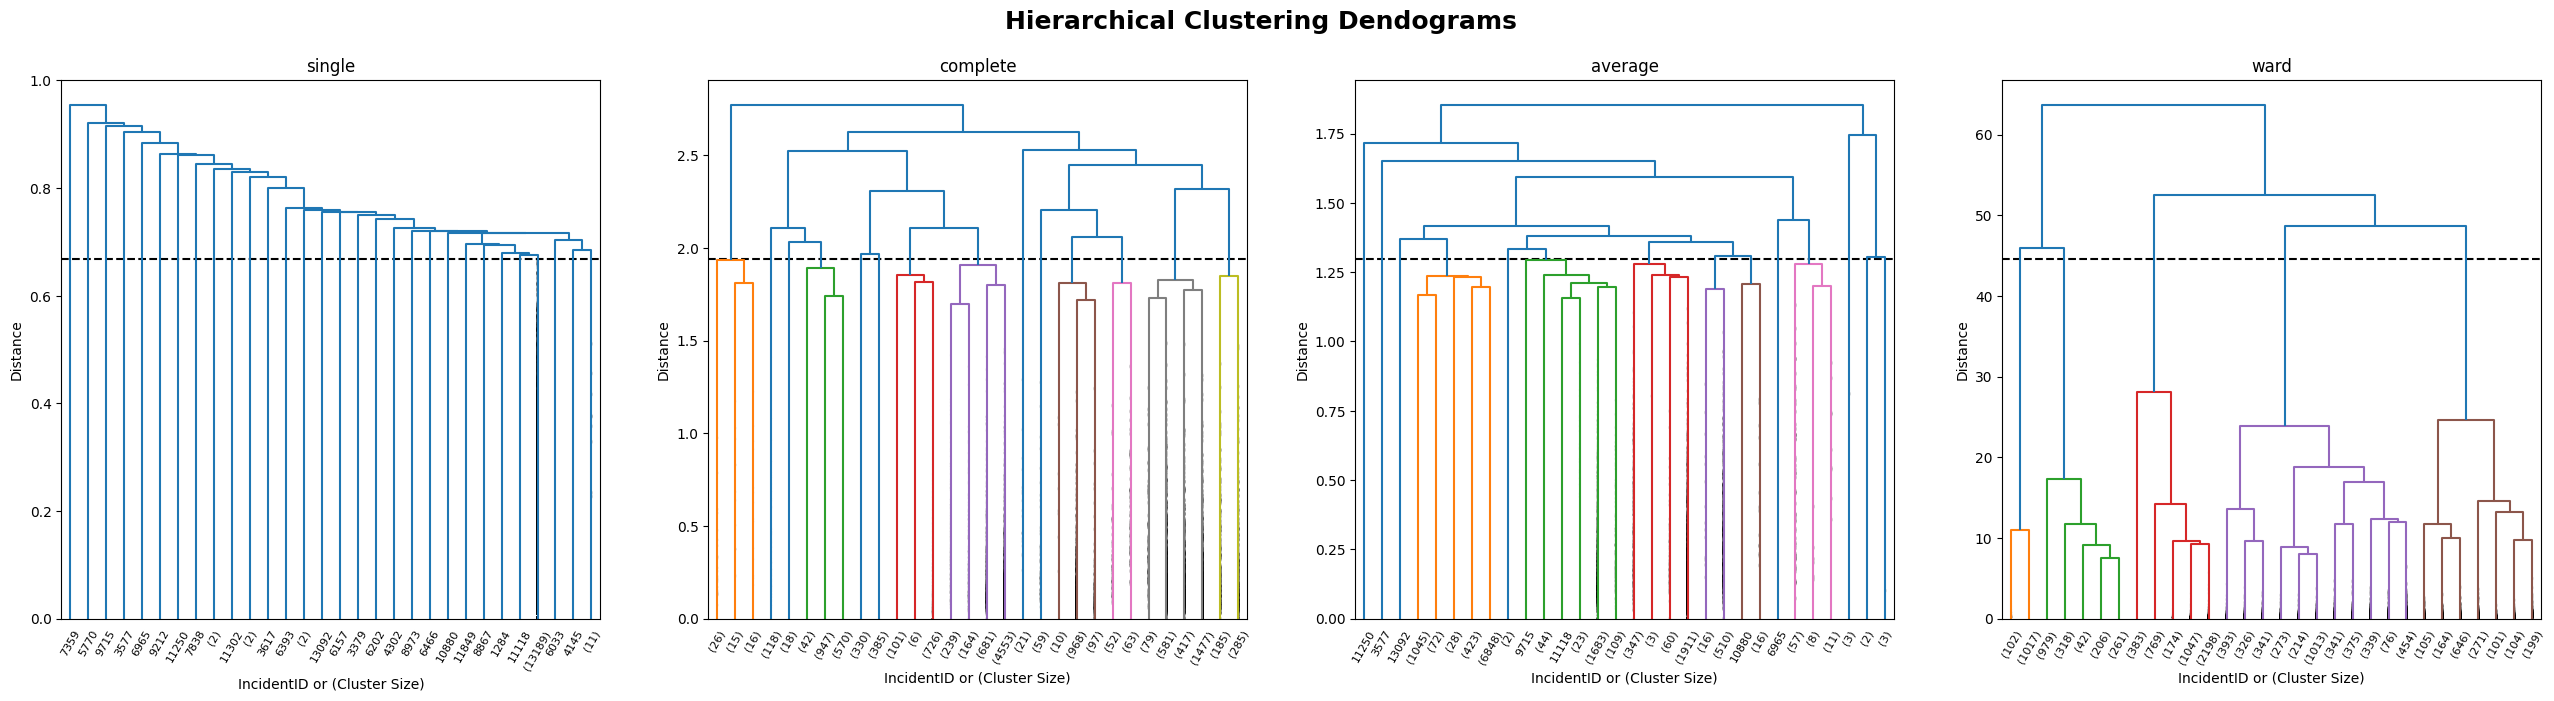

In [48]:
plot_dendrograms(linkages, algorithms, distance_thresholds)

Each proximity measure leads to very different shaped hierarchies.

Using **single-linkage** the result we get is similar to what we could achieve adding incrementally to a starting clusters points in closest clusters.

Using **complete-linkage** the tree is more balanced, however a cluster is significantly bigger than others (the one containing 4553 points).

Using **average-linkage** we find, as expected, a compromise between the results obtained using single and complete linkage.

Using **ward** we get the most balanced results, both in terms of tree structure and in terms of clusters size.

## Clustering evaluation

### Internal indices

To evaluate the clustering results with the different methods we compute the cophenetic correlation coefficient. The cophenetic distance between two objects is the proximity at which an agglomerative hierarchical clustering technique puts the objects in the same cluster for the first time. In a cophenetic distance matrix, the entries are the cophenetic distances between each pair of objects. The cophenetic correlation coefficient measures the correlation between the entries of the cophenetic distance metric and the dissimilarity matrix.

In [49]:
cophenetic_coefs = []
for linkage in linkages:
    cophenetic_matrix = cophenet(linkage)
    cophenetic_coef = np.corrcoef(cophenetic_matrix, dm)[0][1]
    cophenetic_coefs.append(cophenetic_coef)
pd.DataFrame({'algorithm': algorithms, 'cophenetic_coef': cophenetic_coefs})

algorithm  cophenetic_coef
0    single         0.789850
1  complete         0.720990
2   average         0.832911
3      ward         0.699254

The best results are obtained using average linkage.

In the following, we search for the best cut computing the silhouette score for each clustering obtained by cutting the tree at the 10 merging steps with the greatest distance between merged clusters.

In [50]:
ncuts = 10
clusters_info = {}
clusters_info['method'] = []
clusters_info['cut_height'] = []
clusters_info['merging_difference'] = []
clusters_info['cluster_labels'] = []
clusters_info['n_clusters'] = []
clusters_info['clusters_sizes'] = []
clusters_info['silhouette_score'] = []
silhouette_scores = []

for i, algorithm in enumerate(algorithms):
    print(f"Method: {algorithm}-linkage")
    clusters_info['method'].append(algorithm)
    merge_dist = linkages[i][:,2]
    merge_dist_diff = np.array([merge_dist[j + 1] - merge_dist[j] for j in range(len(merge_dist) - 1)])
    sorted_merge_dist_diff_it = np.argsort(-merge_dist_diff)

    best_threshold = 0
    best_distance_diff = 0
    best_labels = []
    best_n_clusters = 0
    best_cluster_sizes = []
    best_silhouette_score = -1
    
    for j in range(ncuts):
        print(f'Computing silhouette score for cut {j+1}/{ncuts}...')
        clusters = np.array(cut_tree(linkages[i], height=merge_dist[sorted_merge_dist_diff_it[j]])).reshape(-1)
        n_clusters = np.unique(clusters).shape[0]
        if (n_clusters > 1):
            silhouette_avg = silhouette_score(X_minmax, clusters)
            if silhouette_avg > best_silhouette_score:
                best_threshold = merge_dist[sorted_merge_dist_diff_it[j]]
                best_distance_diff = merge_dist_diff[sorted_merge_dist_diff_it[j]]
                best_labels = clusters
                best_n_clusters = n_clusters
                counts = np.bincount(clusters)
                best_cluster_sizes = counts[counts!=0]
                best_silhouette_score = silhouette_avg
    
    clusters_info['cut_height'].append(best_threshold)
    clusters_info['merging_difference'].append(best_distance_diff)
    clusters_info['cluster_labels'].append(best_labels)
    clusters_info['n_clusters'].append(best_n_clusters)
    clusters_info['clusters_sizes'].append(best_cluster_sizes)
    clusters_info['silhouette_score'].append(best_silhouette_score)
    silhouette_scores.append(best_silhouette_score)

clusters_info_df = pd.DataFrame(clusters_info)
clusters_info_df.set_index(['method'], inplace=True)
clusters_info_df['cophenetic_correlation_coefficient'] = cophenetic_coefs
clusters_info_df

Method: single-linkage
Computing silhouette score for cut 1/10...
Computing silhouette score for cut 2/10...
Computing silhouette score for cut 3/10...
Computing silhouette score for cut 4/10...
Computing silhouette score for cut 5/10...
Computing silhouette score for cut 6/10...
Computing silhouette score for cut 7/10...
Computing silhouette score for cut 8/10...
Computing silhouette score for cut 9/10...
Computing silhouette score for cut 10/10...
Method: complete-linkage
Computing silhouette score for cut 1/10...
Computing silhouette score for cut 2/10...
Computing silhouette score for cut 3/10...
Computing silhouette score for cut 4/10...
Computing silhouette score for cut 5/10...
Computing silhouette score for cut 6/10...
Computing silhouette score for cut 7/10...
Computing silhouette score for cut 8/10...
Computing silhouette score for cut 9/10...
Computing silhouette score for cut 10/10...
Method: average-linkage
Computing silhouette score for cut 1/10...
Computing silhouette sc

cut_height  merging_difference  \
method                                     
single      0.921333            0.032300   
complete    2.108108            0.094970   
average     1.746068            0.105975   
ward       24.664687            3.480157   

                                             cluster_labels  n_clusters  \
method                                                                    
single    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           3   
complete  [0, 1, 0, 0, 2, 3, 0, 3, 4, 2, 4, 2, 3, 0, 2, ...          10   
average   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           3   
ward      [0, 1, 2, 0, 0, 3, 2, 4, 5, 0, 5, 0, 3, 0, 0, ...           7   

                                             clusters_sizes  silhouette_score  \
method                                                                          
single                                        [13229, 1, 1]          0.317659   
complete  [5637, 833, 2554, 1695, 1190, 715, 470, 21, 59...          0.326098   
average                                       [13223, 3, 5]          0.330568   
ward                [4145, 915, 4188, 1806, 675, 1119, 383]          0.368106   

          cophenetic_correlation_coefficient  
method                                        
single                              0.789850  
complete                            0.720990  
average                             0.832911  
ward                                0.699254

Ward's method achieves the highest silhouette score.

We plot the dendograms displaying the best cut heights:

C:\Users\lucam\AppData\Local\Temp\ipykernel_19716\238914077.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[i].axhline(thresholds[i], ls='--', color='k', label='threshold')
C:\Users\lucam\AppData\Local\Temp\ipykernel_19716\238914077.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color_threshold = thresholds[i]
C:\Users\lucam\AppData\Local\Temp\ipykernel_19716\238914077.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

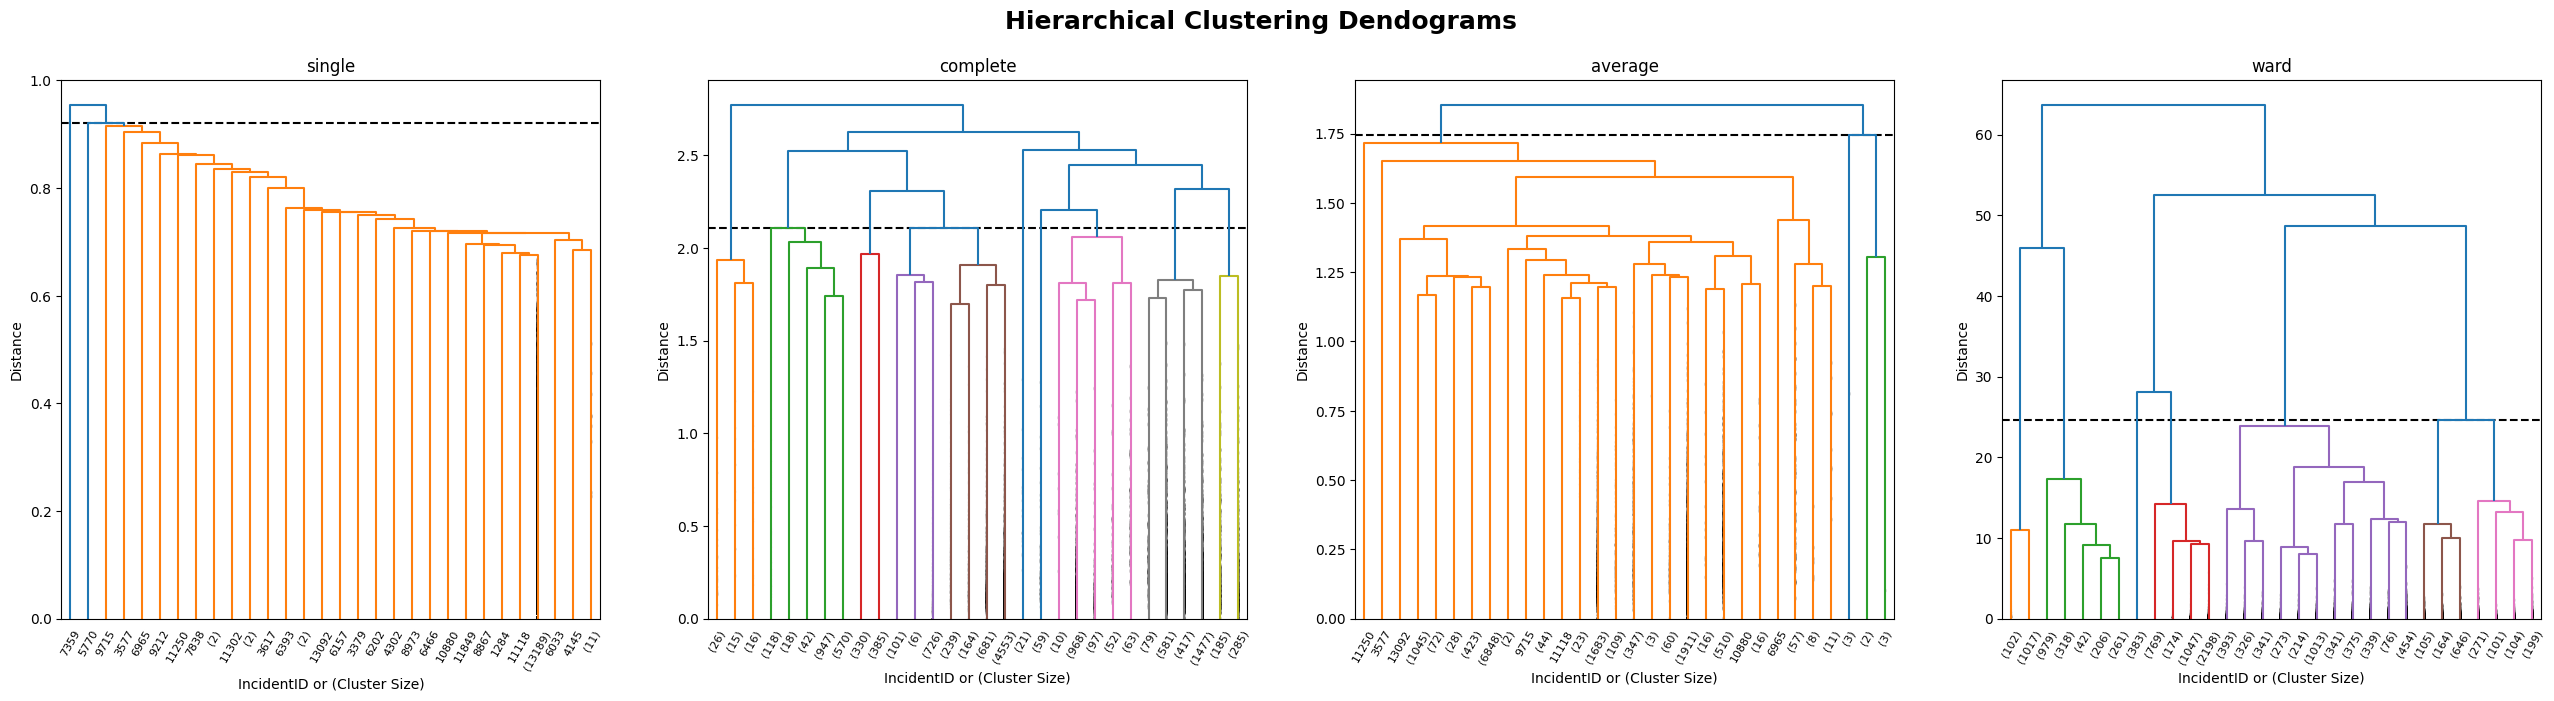

In [51]:
plot_dendrograms(linkages, algorithms, clusters_info_df['cut_height'])

We display the distance between merged clusters at each iteration:

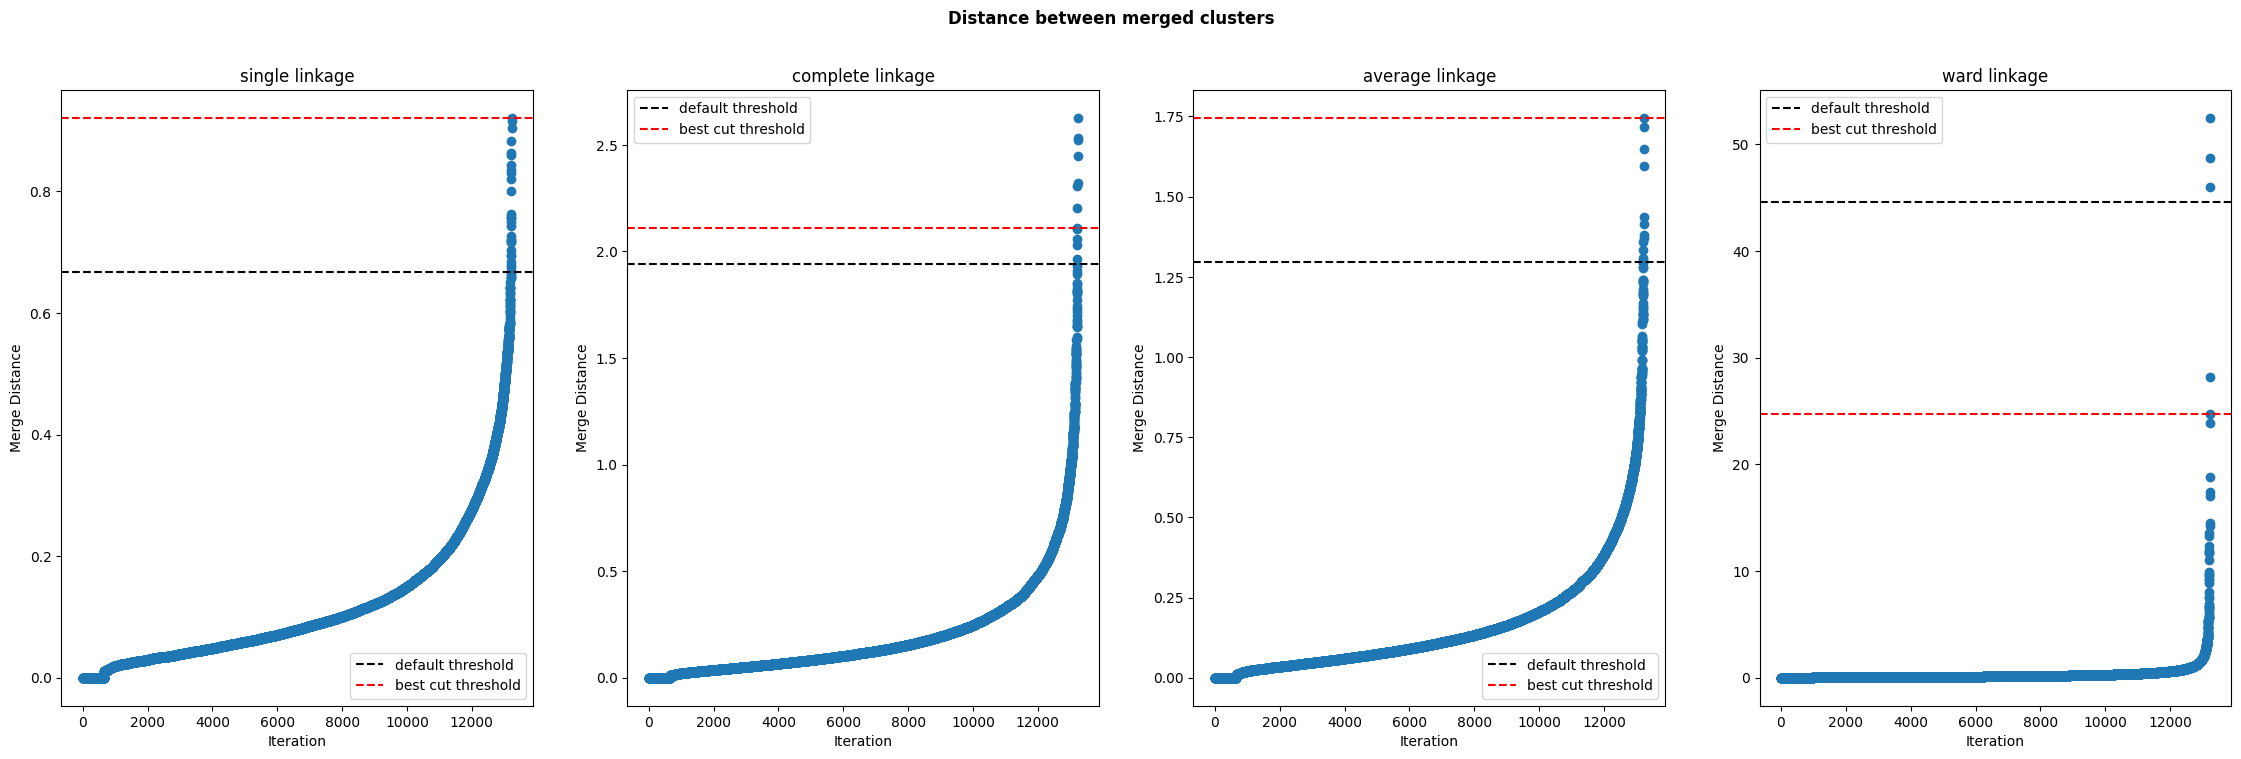

In [52]:
fig, axs = plt.subplots(ncols=4, figsize=(28, 8))
for i, method in enumerate(clusters_info_df.index):
    axs[i].plot(range(0, linkages[i].shape[0]-1), linkages[i][0:-1, 2], 'o')
    axs[i].axhline(distance_thresholds[i], ls='--', color='k', label='default threshold')
    axs[i].axhline(clusters_info_df.loc[method]['cut_height'], ls='--', color='r', label='best cut threshold')
    axs[i].legend()
    axs[i].set_title(f'{method} linkage')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Merge Distance')
fig.suptitle('Distance between merged clusters', fontweight='bold');

The best cuts according to the silhouette score do not correspond to the largest distances between merged clusters.

We plot the silhouette scores for each point:

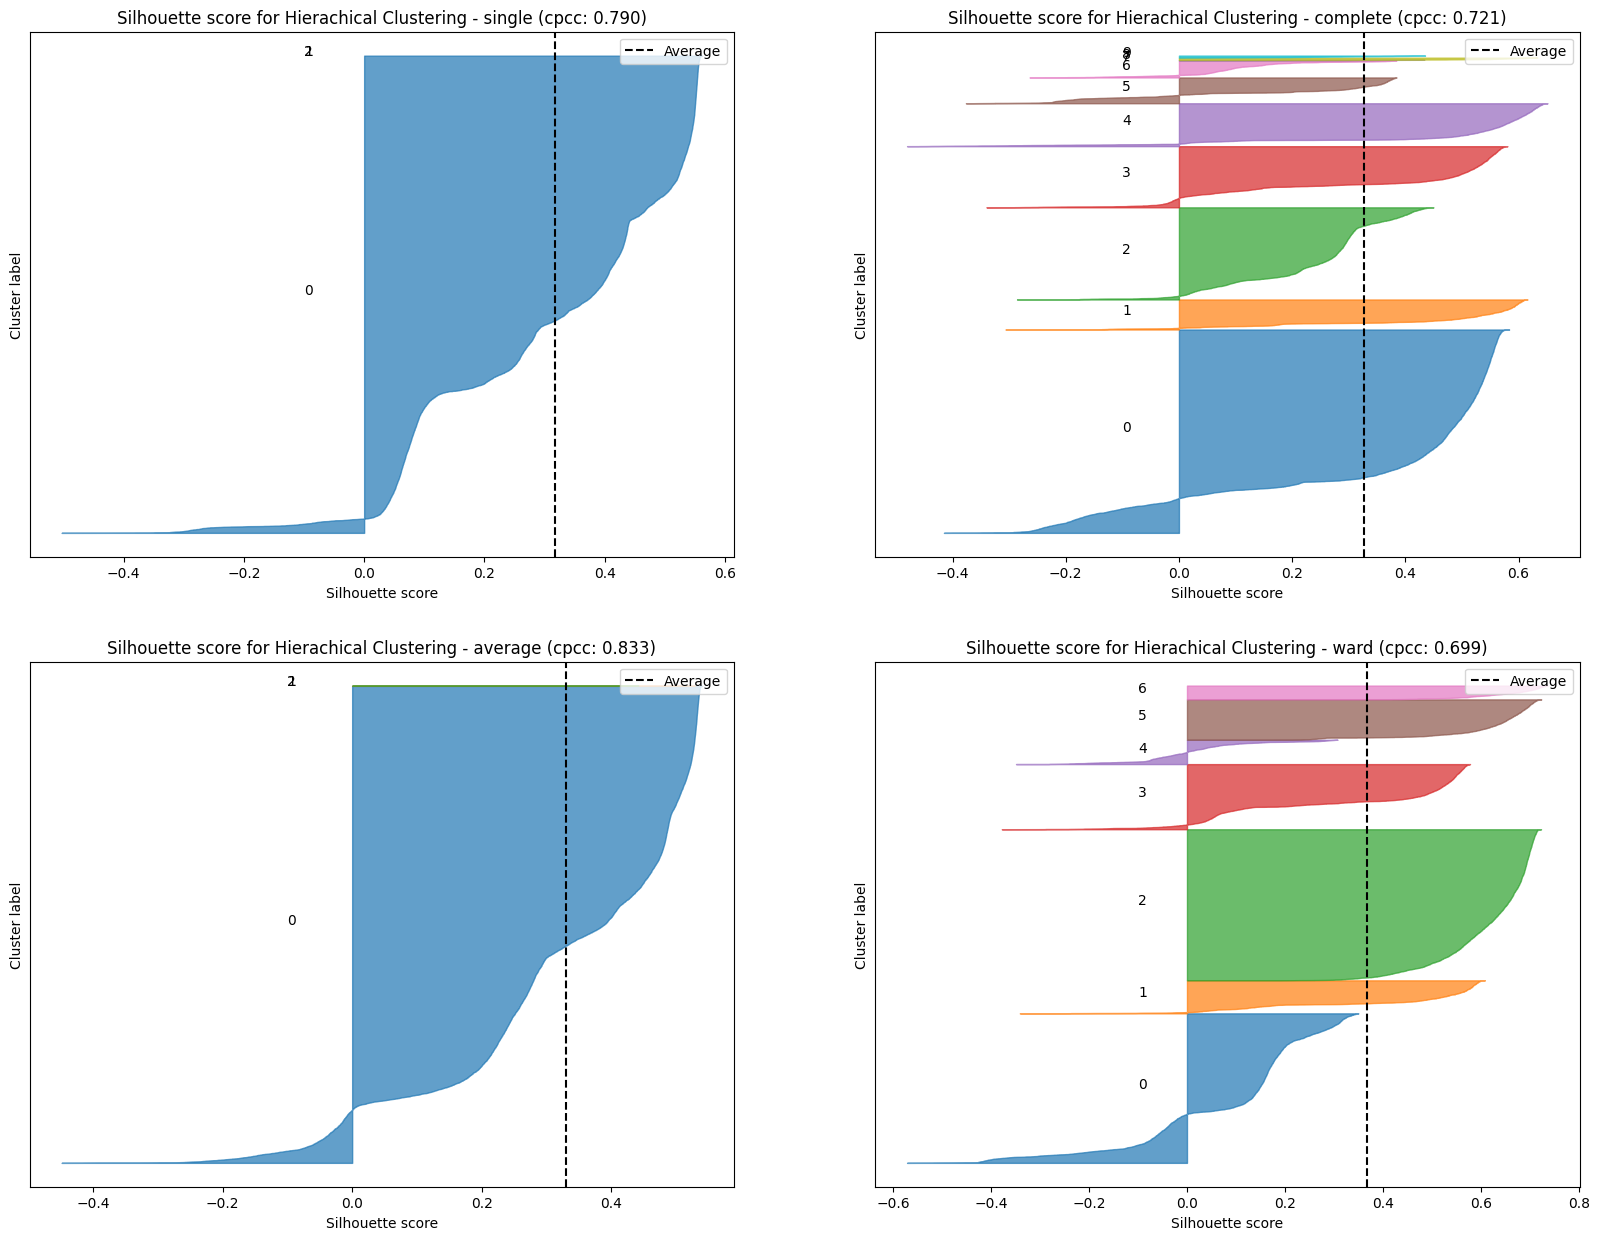

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
x_axs = 0
y_axs = 0
for i, method in enumerate(clusters_info_df.index):
    silhouette_per_point = silhouette_samples(X=X_minmax, labels=clusters_info_df.loc[method]['cluster_labels'])
    if i != 0 and i%2 == 0:
        x_axs += 1
        y_axs = 0
    plot_scores_per_point(
        score_per_point=silhouette_per_point,
        clusters=clusters_info_df.loc[method]['cluster_labels'],
        score_name='Silhouette score',
        ax=axs[x_axs][y_axs],
        title=(f'Silhouette score for Hierachical Clustering - {method} (cpcc: {clusters_info_df.loc[method]["cophenetic_correlation_coefficient"]:.3f})'),
    )
    y_axs += 1

With complete linkage almost every cluster has some points with negative silhouette score. With ward linkage cluster 6, 5 and 2 don't have any points with negative silhouette score. Cluster has 0 the lowest values of silhouette score.

We visualize the size of the clusters:

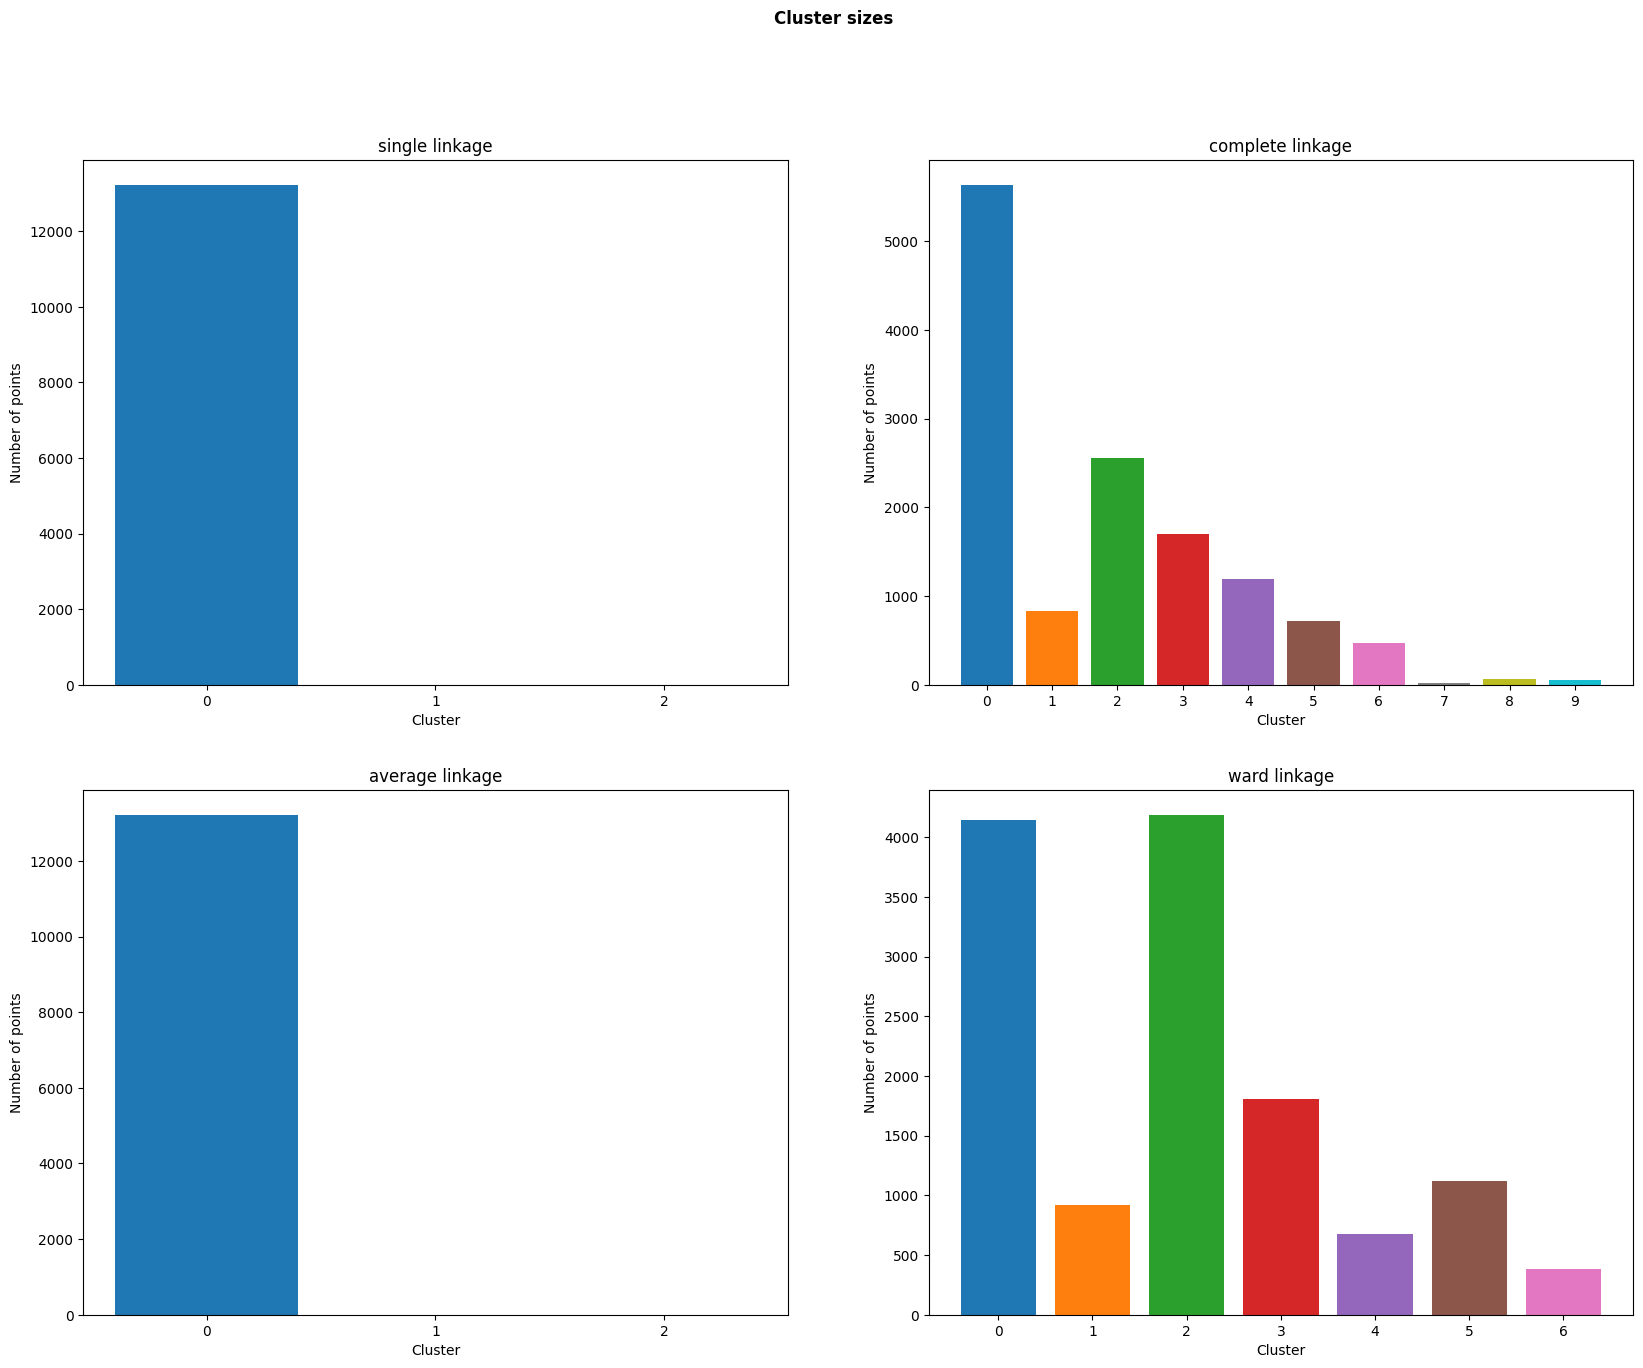

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
x_axs = 0
y_axs = 0
for i, method in enumerate(clusters_info_df.index):
    if i != 0 and i%2 == 0:
        x_axs += 1
        y_axs = 0
    plot_clusters_size(clusters_info_df.loc[method]['cluster_labels'], ax=axs[x_axs][y_axs], title=f'{method} linkage')
    y_axs += 1
fig.suptitle("Cluster sizes", fontweight='bold');

With Ward's method clusters are more balanced.

Since we have some methods with very unbalanced cluster classification, we try an alternative to determine the cut threshold. Here we look at the difference of the merging distances of two clusters, and we set the threshold there, so that we can may get a balanced cluster configuration.

In [55]:
thresholds_balanced = []
silhouette_scores_balanced = []

balanced_clusters_info = {}
balanced_clusters_info['method'] = []
balanced_clusters_info['cut_height'] = []
balanced_clusters_info['merging_difference'] = []
balanced_clusters_info['cluster_labels'] = []
balanced_clusters_info['n_clusters'] = []
balanced_clusters_info['clusters_sizes'] = []
balanced_clusters_info['silhouette_score'] = []
silhouette_scores = []

for i, algorithm in enumerate(algorithms):
    # we set the threshold where we have maximum distance between two merges
    merge_dist = linkages[i][:,2]
    merge_dist_diff = np.array([merge_dist[j + 1] - merge_dist[j] for j in range(len(merge_dist) - 1)])
    sorted_merge_dist_diff_it = np.argsort(-merge_dist_diff)
    thresholds_balanced.append(merge_dist[[sorted_merge_dist_diff_it[0]]])

    clusters = np.array(cut_tree(linkages[i], height=merge_dist[sorted_merge_dist_diff_it[0]])).reshape(-1)
    n_clusters = np.unique(clusters).shape[0]
    silhouette_avg = silhouette_score(X_minmax, clusters) # compute silhouette for this cut
    silhouette_scores_balanced.append(silhouette_avg)


    balanced_clusters_info['method'].append(algorithm)
    balanced_clusters_info['cut_height'].append(merge_dist[sorted_merge_dist_diff_it[0]])
    balanced_clusters_info['merging_difference'].append(merge_dist_diff[sorted_merge_dist_diff_it[0]])
    balanced_clusters_info['cluster_labels'].append(clusters)
    balanced_clusters_info['n_clusters'].append(n_clusters)
    counts = np.bincount(clusters)
    balanced_clusters_info['clusters_sizes'].append(counts[counts!=0])
    balanced_clusters_info['silhouette_score'].append(silhouette_avg)

balanced_clusters_info_df = pd.DataFrame(balanced_clusters_info)

We plot again the dendrograms with the new chosen cut, the new distribution of the clusters and some info on the results we get.

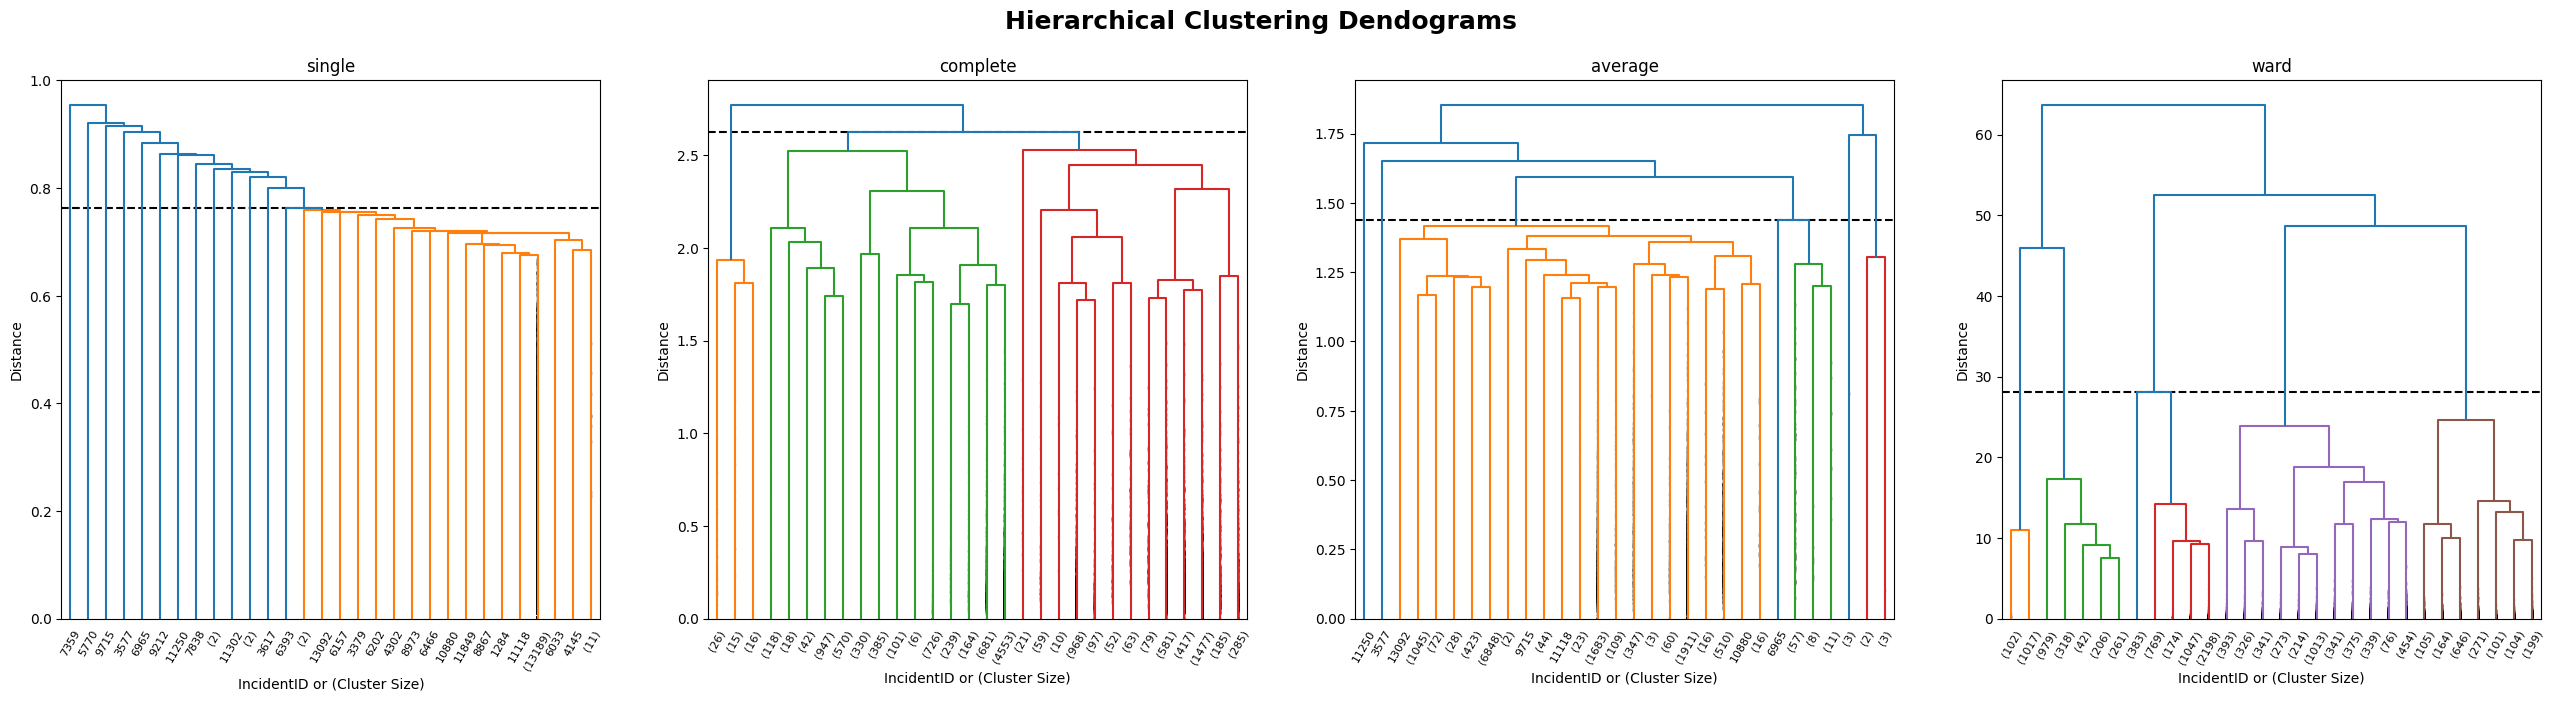

In [56]:
plot_dendrograms(linkages, algorithms, balanced_clusters_info_df['cut_height'])

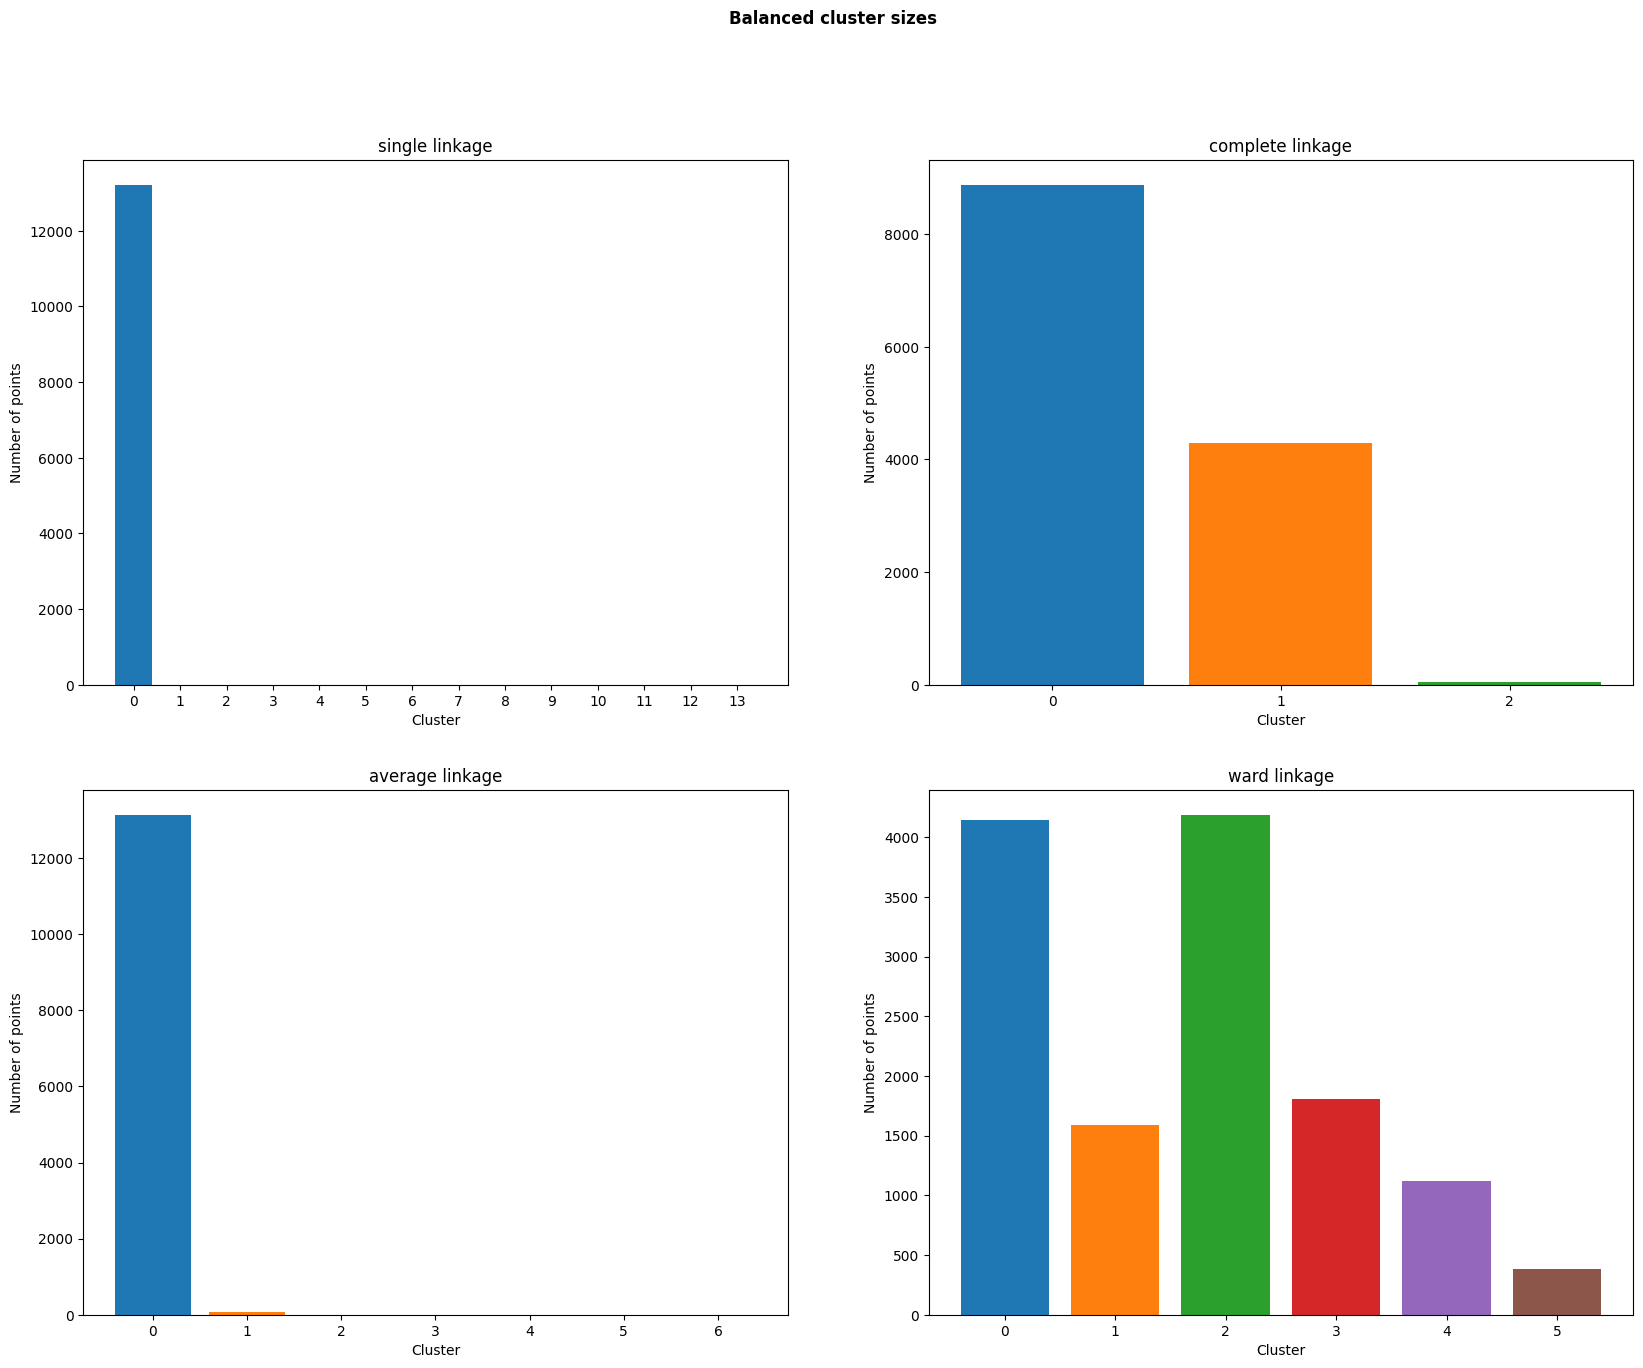

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
x_axs = 0
y_axs = 0
for i, method in enumerate(clusters_info_df.index):
    if i != 0 and i%2 == 0:
        x_axs += 1
        y_axs = 0
    plot_clusters_size(balanced_clusters_info_df.loc[i]['cluster_labels'], ax=axs[x_axs][y_axs], title=f'{method} linkage')
    y_axs += 1
fig.suptitle("Balanced cluster sizes", fontweight='bold');

In [58]:
balanced_clusters_info_df

method  cut_height  merging_difference  \
0    single    0.763672            0.036777   
1  complete    2.626983            0.142518   
2   average    1.437300            0.157492   
3      ward   28.144844           17.819046   

                                      cluster_labels  n_clusters  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          14   
1  [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, ...           3   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           7   
3  [0, 1, 2, 0, 0, 3, 2, 1, 4, 0, 4, 0, 3, 0, 0, ...           6   

                                   clusters_sizes  silhouette_score  
0  [13216, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]          0.132843  
1                                [8880, 4294, 57]          0.189700  
2                      [13144, 76, 3, 5, 1, 1, 1]          0.200359  
3             [4145, 1590, 4188, 1806, 1119, 383]          0.353889

As we can see from the cluster distribution, the situation didn't change a lot; moreover, as obvious, the silhouette scores get worse. The only method wich still gives a little balanced result is **ward**, but this is given by the fact that the cut height didn't change too much. <br>
We see that **single** and **average** methods have a similar situation where one main cluster contains all the points of the dataset, so we want to choose ourselves a threshold that could give a more uniform distribution of clusters. We do this by looking at the dendrograms and at the merging behavior of the algorithms.
But since we already know **single-linkage** will anyway accumulate points in a single cluster, we do this analisys only for average.

In [59]:
merge_dist = linkages[2][:,2]
merge_dist_diff = np.array([merge_dist[j + 1] - merge_dist[j] for j in range(len(merge_dist) - 1)])

clusters = np.array(cut_tree(linkages[2], height=merge_dist[len(merge_dist) - 10])).reshape(-1)
n_clusters = np.unique(clusters).shape[0]
silhouette_avg = silhouette_score(X_minmax, clusters) # compute silhouette for this cut
silhouette_scores_balanced.append(silhouette_avg)


balanced_clusters_info_df.at[2, 'cut_height'] = merge_dist[len(merge_dist) - 10]
balanced_clusters_info_df.at[2, 'merging_difference'] = merge_dist_diff[len(merge_dist_diff) - 10]
balanced_clusters_info_df.at[2, 'cluster_labels'] = clusters
balanced_clusters_info_df.at[2, 'n_clusters'] = n_clusters
counts = np.bincount(clusters)
balanced_clusters_info_df.at[2, 'clusters_sizes'] = counts[counts!=0]
balanced_clusters_info_df.at[2, 'silhouette_score'] = silhouette_avg

We display the same plots and results ad done before.

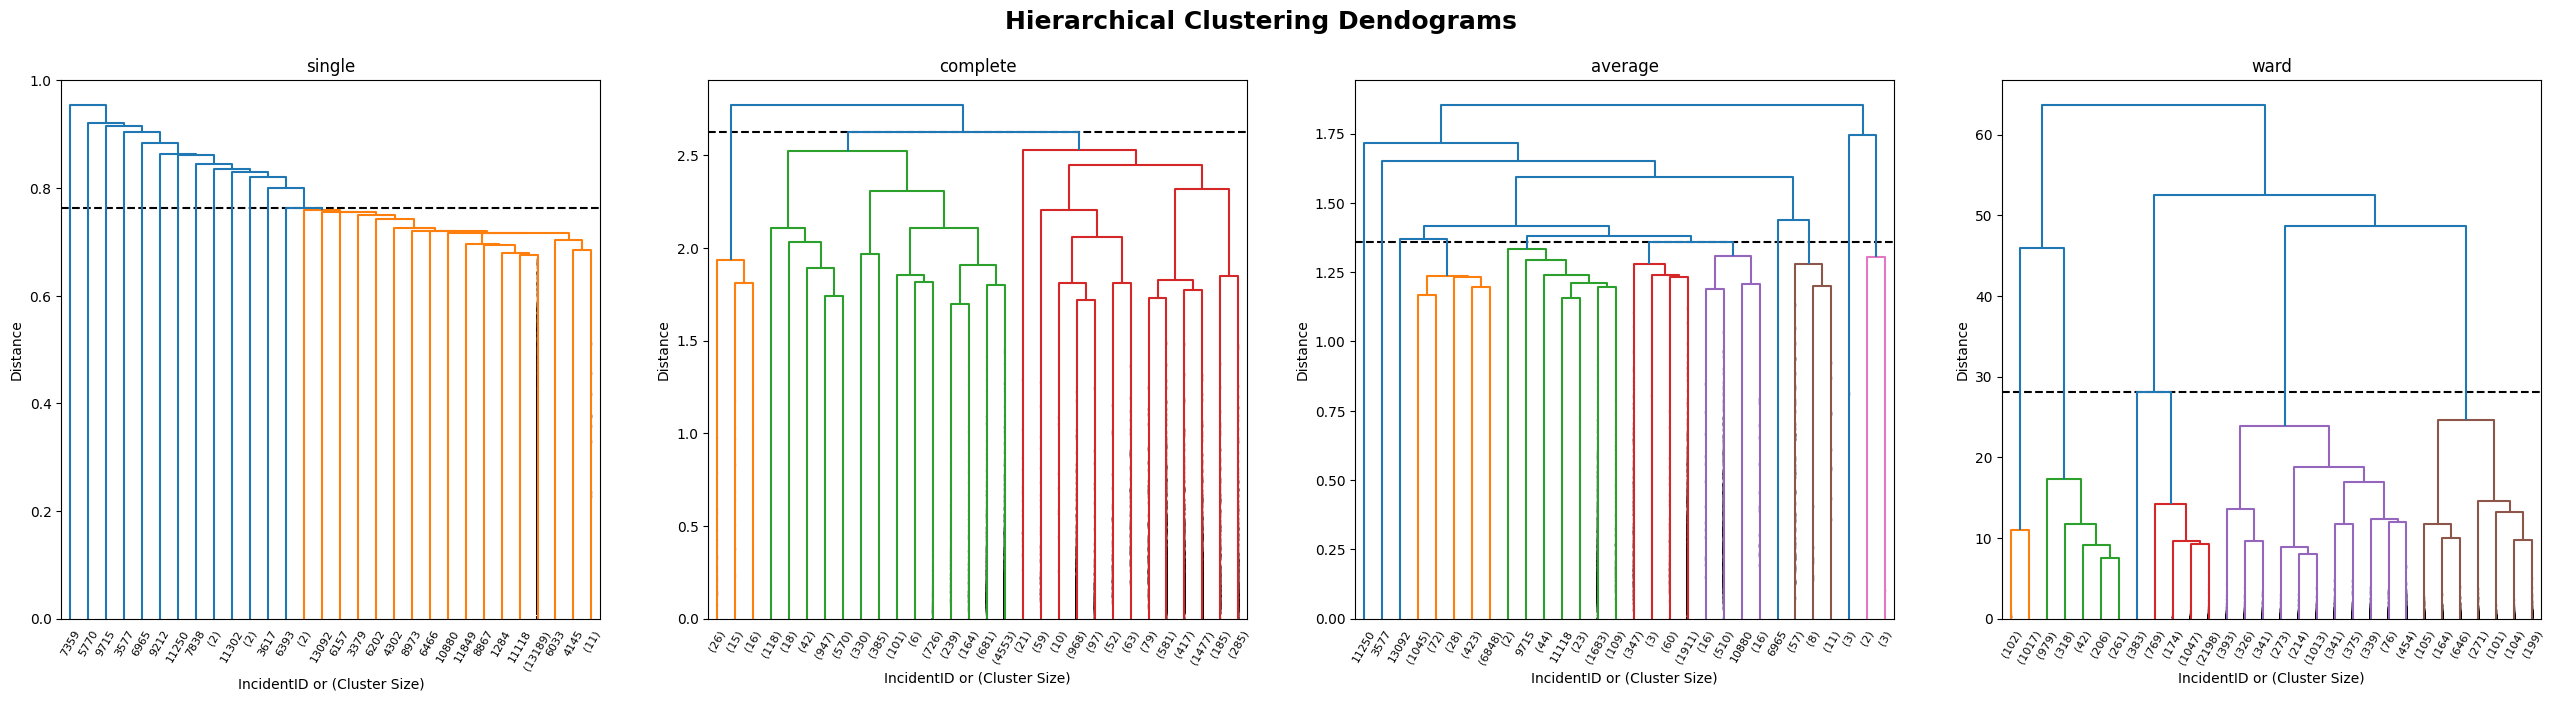

In [60]:
plot_dendrograms(linkages, algorithms, balanced_clusters_info_df['cut_height'])

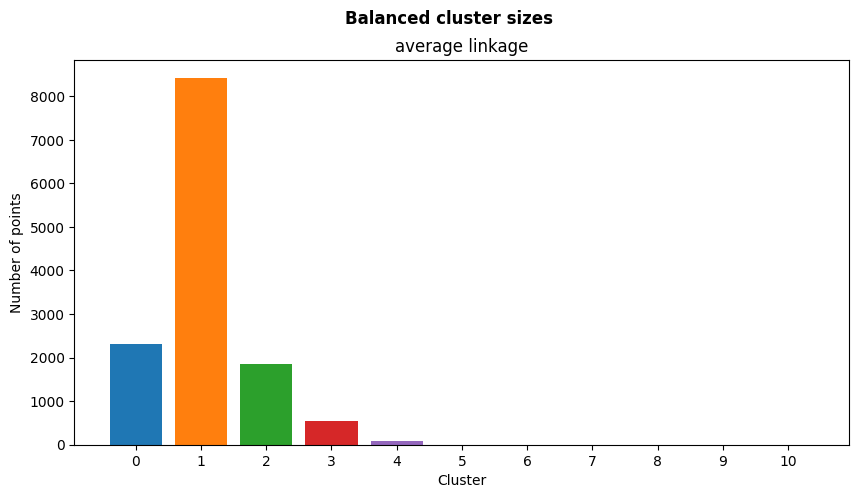

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot_clusters_size(balanced_clusters_info_df.loc[2]['cluster_labels'], ax=ax, title='average linkage')
fig.suptitle("Balanced cluster sizes", fontweight='bold');

In [62]:
balanced_clusters_info_df

method  cut_height  merging_difference  \
0    single    0.763672            0.036777   
1  complete    2.626983            0.142518   
2   average    1.358893            0.025212   
3      ward   28.144844           17.819046   

                                      cluster_labels  n_clusters  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...          14   
1  [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, ...           3   
2  [0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, ...          11   
3  [0, 1, 2, 0, 0, 3, 2, 1, 4, 0, 4, 0, 3, 0, 0, ...           6   

                                   clusters_sizes  silhouette_score  
0  [13216, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]          0.132843  
1                                [8880, 4294, 57]          0.189700  
2   [2321, 8416, 1863, 543, 76, 3, 5, 1, 1, 1, 1]          0.274724  
3             [4145, 1590, 4188, 1806, 1119, 383]          0.353889

The situation became a little bit better since now we still have a dominant cluster, but it's not formed by almost all the points anymore. By increasing the number of clusters, the previous main one divide itself in one big cluster and some other one which are still small, but not composed by a negligible number of points. <br>
Moreover we can see that with this cut we increased the silhouette score.

We visualize the distance matrix sorted by cluster computed on a stratified subsample of 500 points for complete and Ward linkage:

(array([[0.        , 1.11660198, 1.06779053, ..., 1.49461551, 1.54380201,
         1.5129555 ],
        [1.11660198, 0.        , 0.48429118, ..., 1.29281751, 1.27579296,
         1.30263857],
        [1.06779053, 0.48429118, 0.        , ..., 1.36387146, 1.39752277,
         1.33693204],
        ...,
        [1.49461551, 1.29281751, 1.36387146, ..., 0.        , 0.23975542,
         0.3274579 ],
        [1.54380201, 1.27579296, 1.39752277, ..., 0.23975542, 0.        ,
         0.39557714],
        [1.5129555 , 1.30263857, 1.33693204, ..., 0.3274579 , 0.39557714,
         0.        ]]),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]))

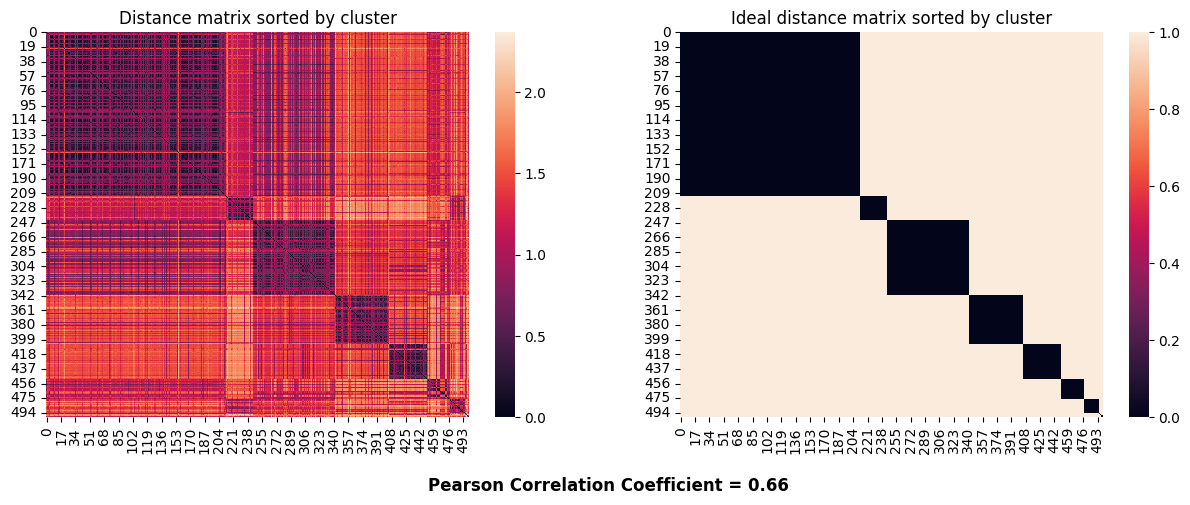

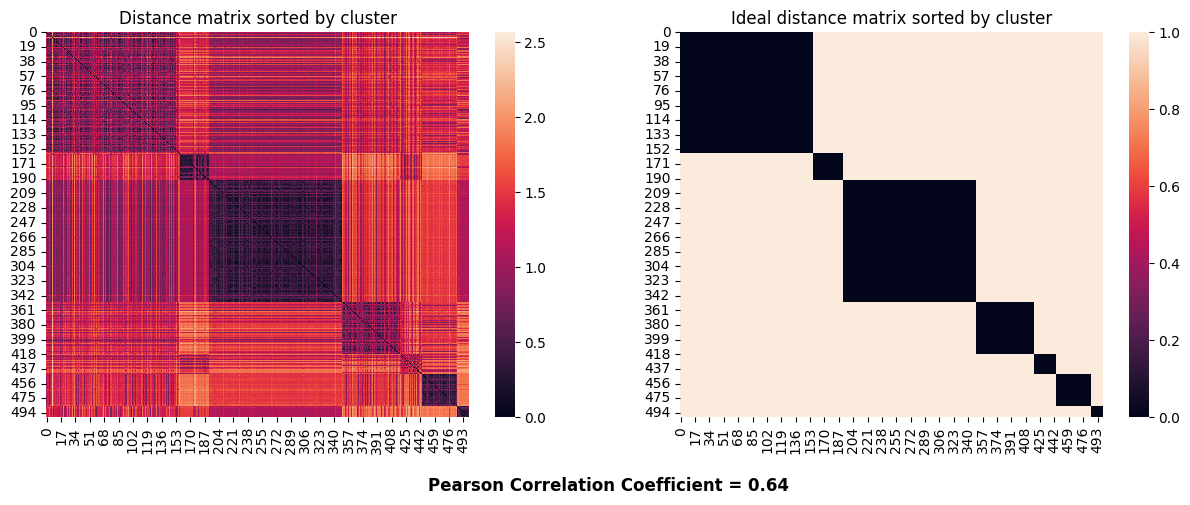

In [63]:
plot_distance_matrices(X=X_minmax, n_samples=500, clusters=clusters_info_df.loc['complete']['cluster_labels'], random_state=RANDOM_STATE)
plot_distance_matrices(X=X_minmax, n_samples=500, clusters=clusters_info_df.loc['ward']['cluster_labels'], random_state=RANDOM_STATE)

This kind of evaluation is not very informative for hierarchical clustering, since the clusters could not be globular and may be intertwined with other clusters.
Nevertheless, both the matrices have a block diagonal structure, meaning that clusters are well separated.

Since with Ward's method we get the best results in terms of silhouette score and cluster size, we will use this method for the following analysis.

In [64]:
best_method = 'ward'

We visualize the cluster in the bidimensional feature spaces obtained pairing some features used for the clustering:

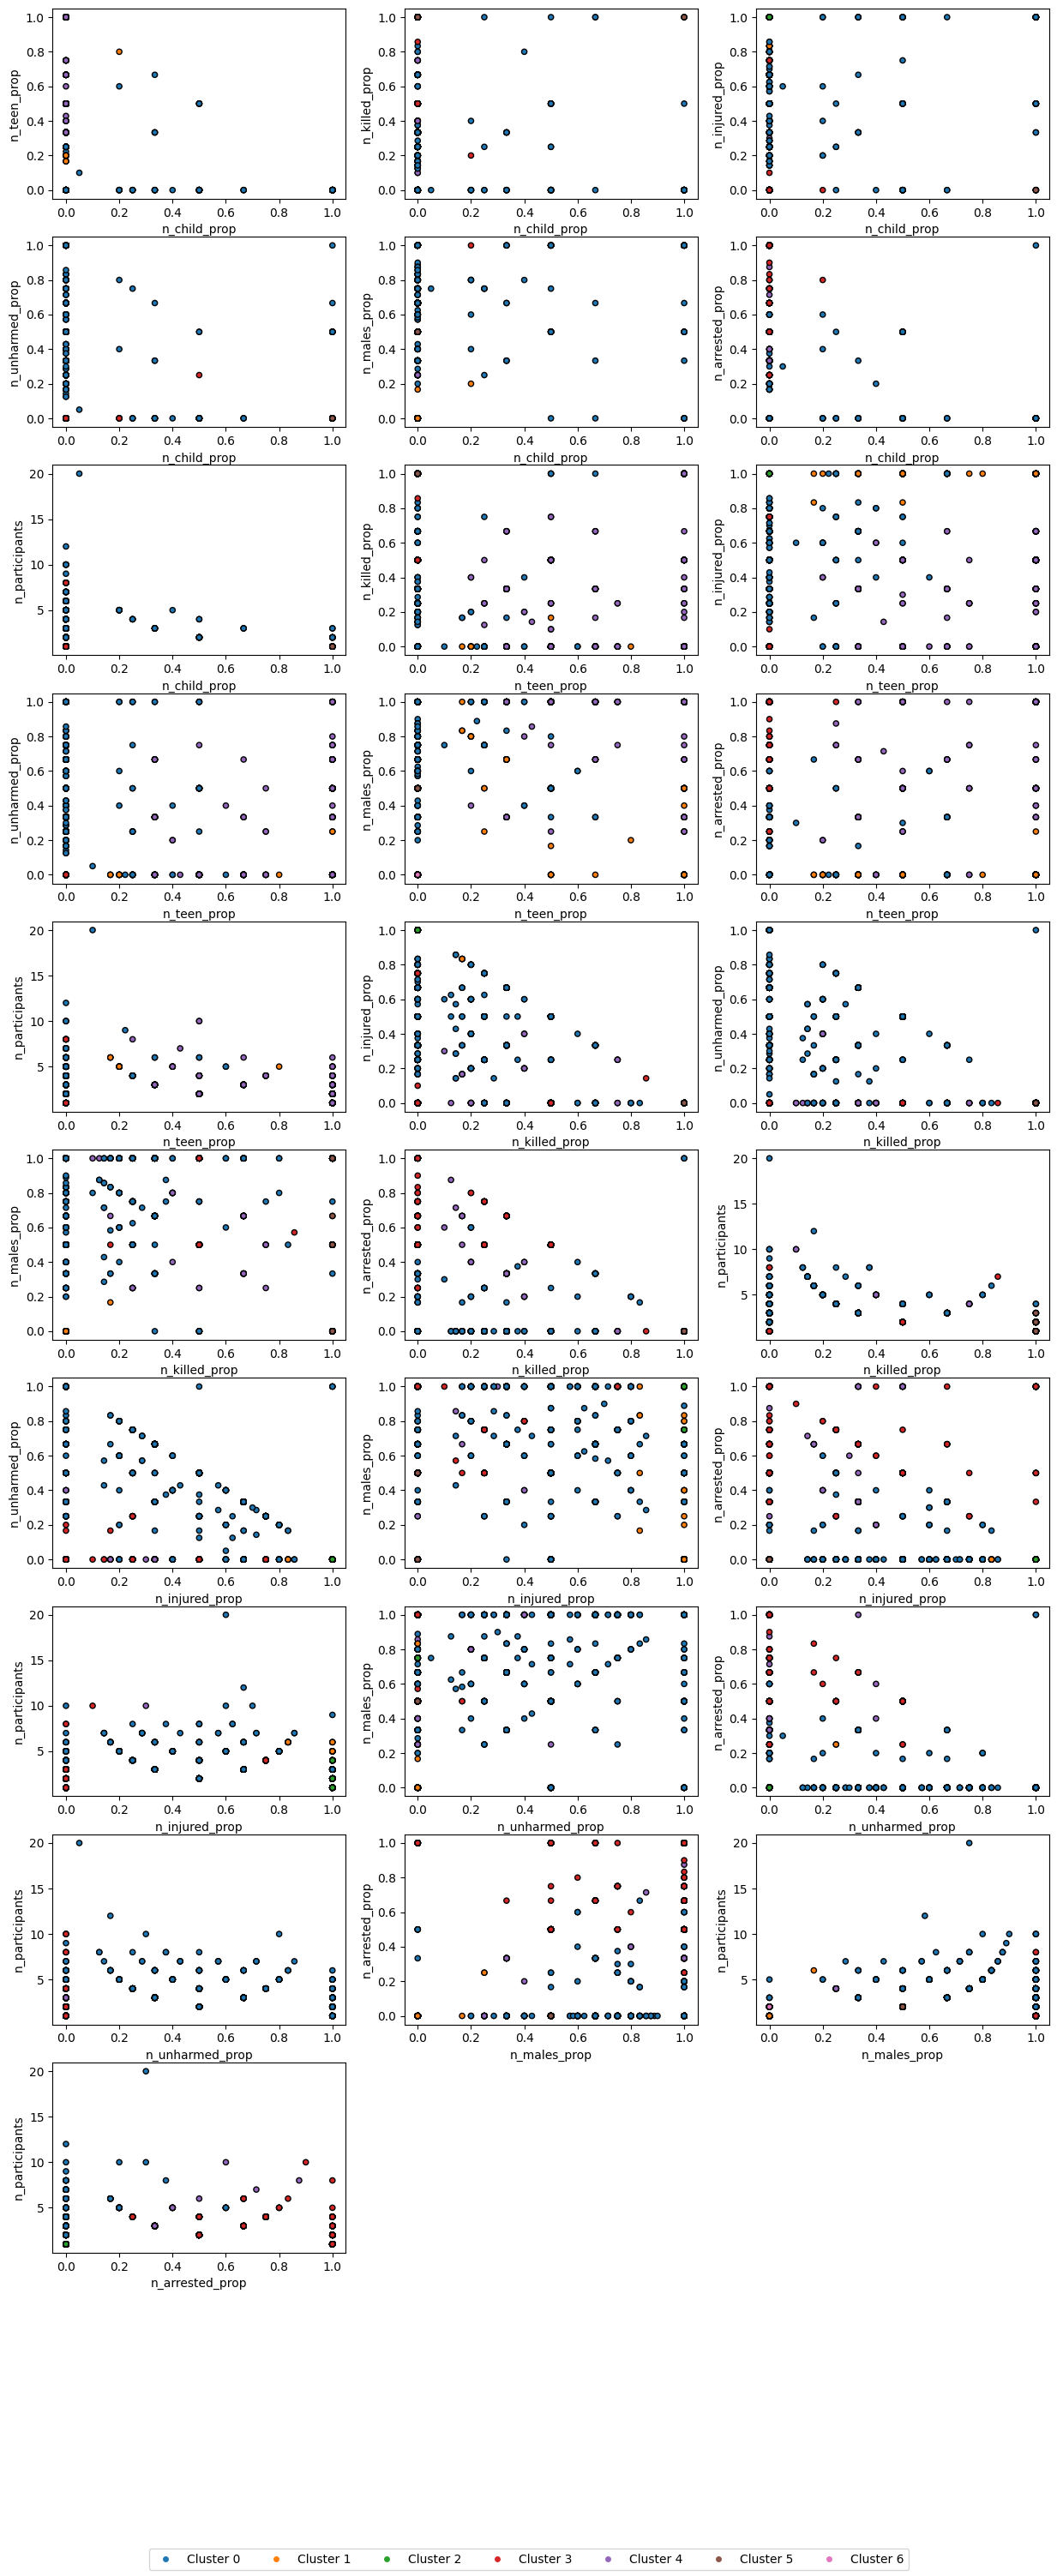

In [65]:
incidents_df['cluster'] = clusters_info_df.loc[best_method]['cluster_labels']
features_to_scatter = [
    'n_child_prop',
    'n_teen_prop',
    'n_killed_prop',
    'n_injured_prop',
    'n_unharmed_prop',
    'n_males_prop',
    'n_arrested_prop',
    'n_participants'
]
scatter_by_cluster(
    df=incidents_df,
    features=features_to_scatter,
    cluster_column='cluster',
    figsize=(15, 34)
)

In some feature spaces clusters are almost well separated.

We apply the principal component analysis to the scaled matrix of indicators:

In [66]:
pca = PCA()
X_pca = pca.fit_transform(X_minmax)

We display the explained variance ratio of the components:

[0, 1, 2, 3.5, 5.0, 6.5, 7.5, 9.0, 10.0, 11.5, 12.5, 13.5, 15.0, 16.0, 17.5, 18.5]


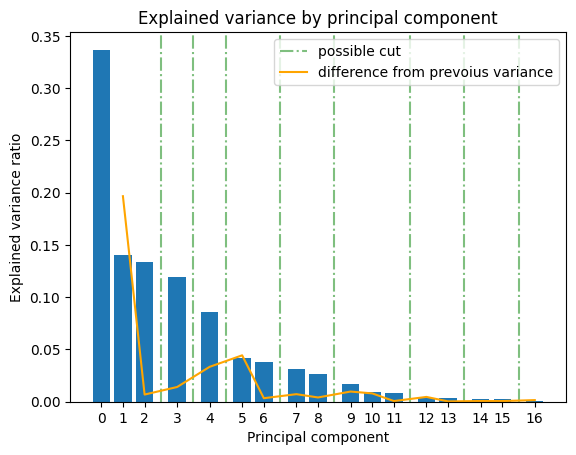

In [67]:
exp_var_pca = pca.explained_variance_ratio_

diff_var = []
for i, var in enumerate(exp_var_pca[:-1]):
    diff_var.append( var-exp_var_pca[i+1])
xtick = []
gap = 0
for i, var in enumerate(diff_var):
    xtick.append(i+gap)
    if i != 0 and diff_var[i-1] <= var:
        gap += 0.5
        if gap == 0.5:
            plt.axvline(x = i+gap+0.25, color = 'green', linestyle = '-.', alpha=0.5, label='possible cut')
        else:
            plt.axvline(x = i+gap+0.25, color = 'green', linestyle = '-.', alpha=0.5)
print(xtick)
xtick.append(xtick[-1]+1.5)

plt.bar(xtick, exp_var_pca, align='center')
plt.plot(xtick[1:], diff_var, label='difference from prevoius variance', color='orange')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.title('Explained variance by principal component')
plt.xticks(xtick, range(exp_var_pca.shape[0]));
plt.legend();

The first 6 components contribute the most to the overall variance in the dataset.

We visualize the clusters in the feature spaces obtained by pairing the first 6 principal components:

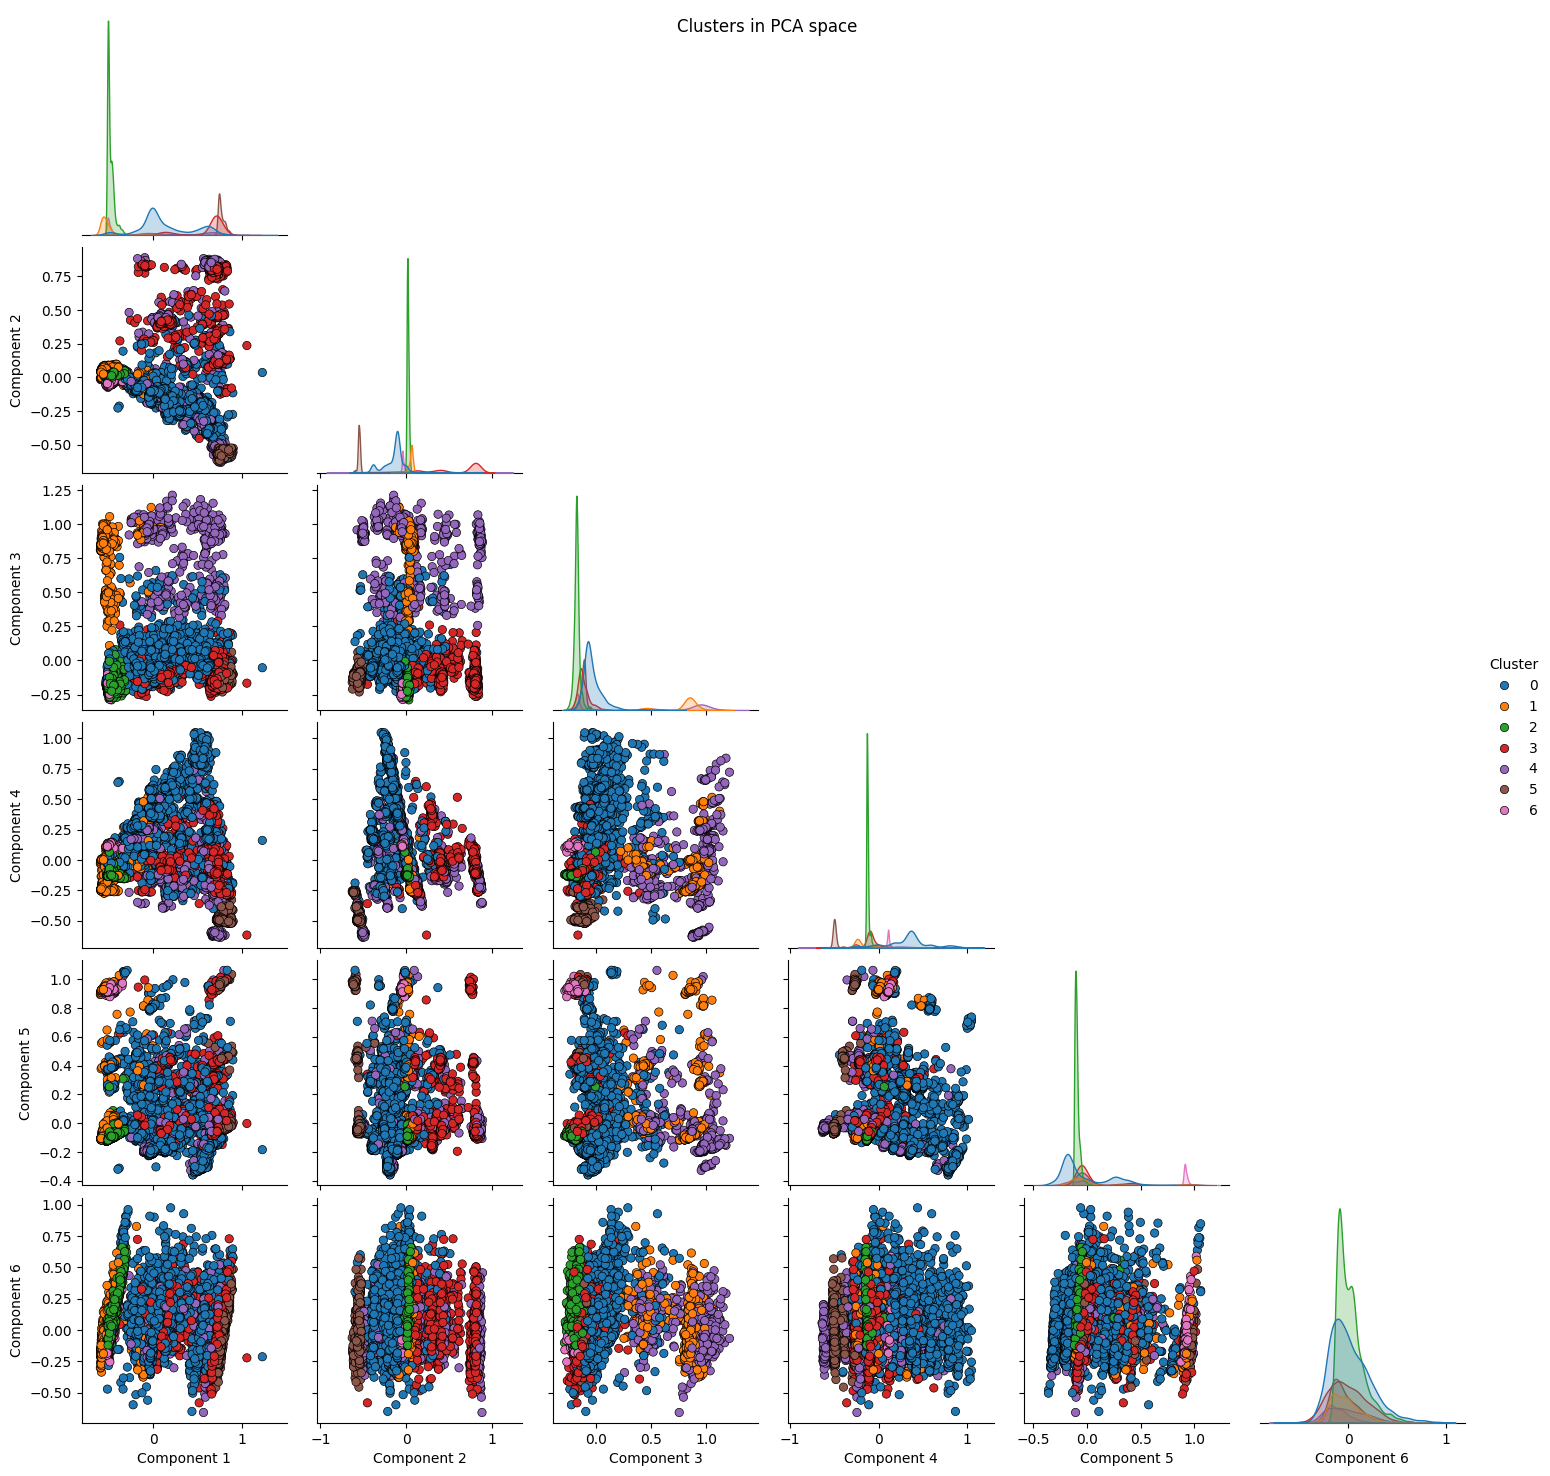

In [68]:
n_clusters = len(np.unique(incidents_df['cluster']))
palette = [sns.color_palette('tab10')[i] for i in range(n_clusters)]
scatter_pca_features_by_cluster(
    X_pca=X_pca,
    n_components=6,
    clusters=incidents_df['cluster'],
    palette=palette,
    hue_order=None,
    title='Clusters in PCA space'
)

In the feature spaces involving the third principal components clusters are almost well separated.

We now visualize the distributions of the features used to cluster the data in each cluster:

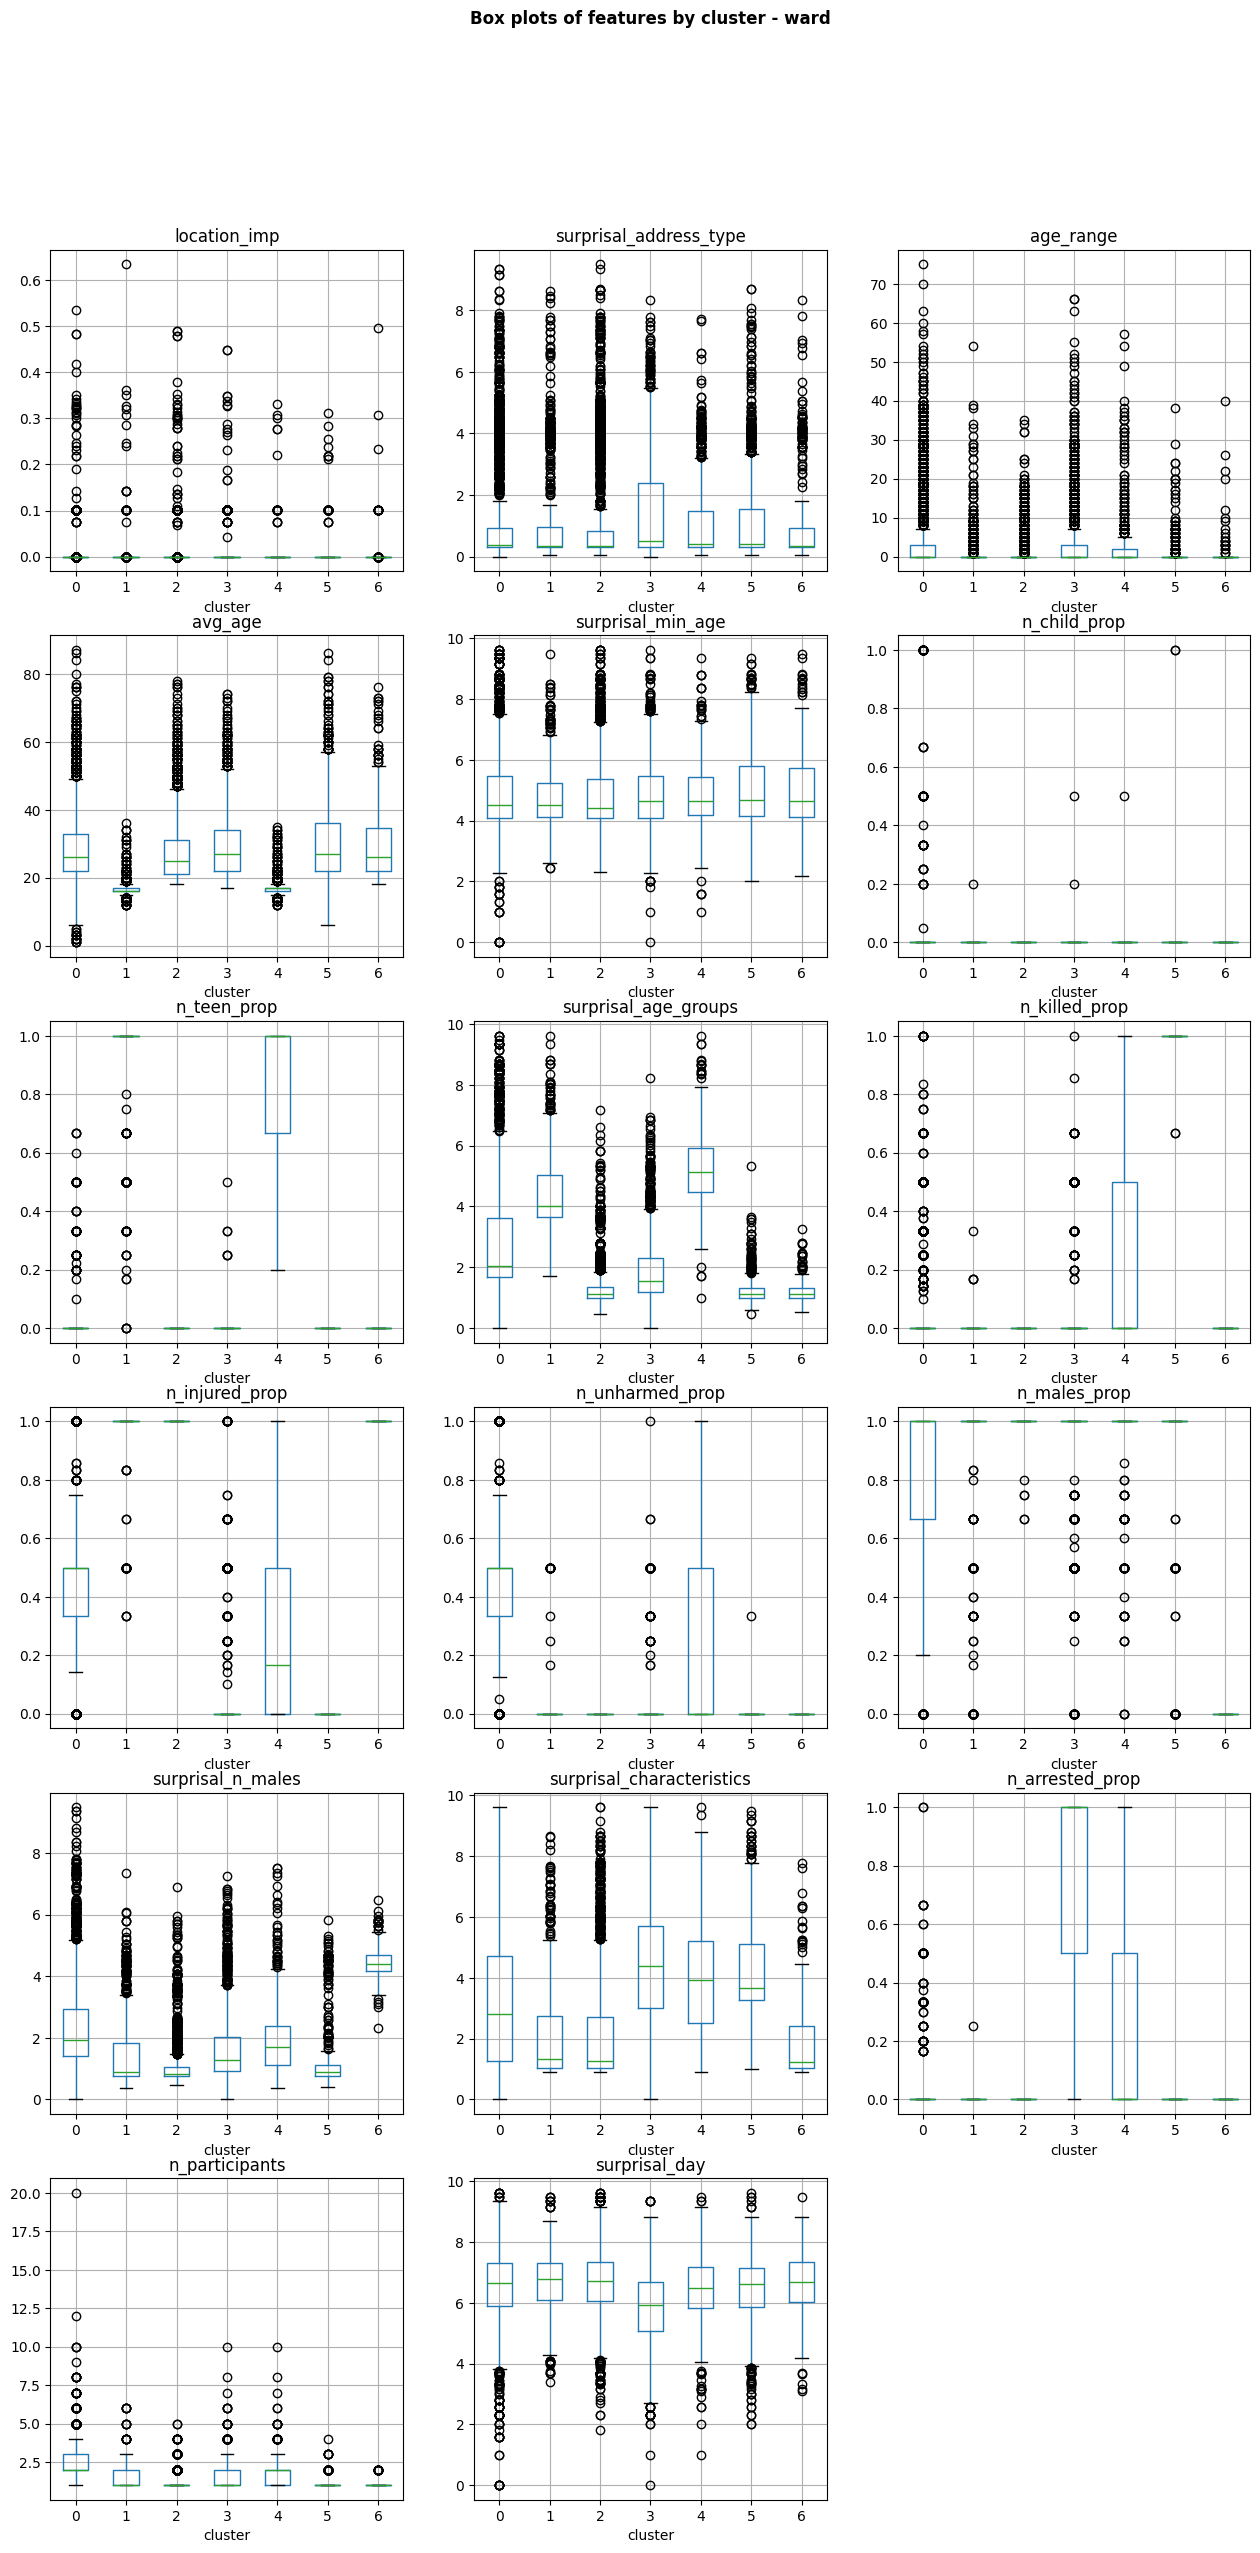

In [69]:
plot_boxes_by_cluster(
    df=incidents_df,
    features=indicators_df.columns,
    cluster_column='cluster',
    figsize=(15, 30),
    title=(f'Box plots of features by cluster - {best_method}')
)

We observe that:
- Cluster 0 has higher values for age_range, n_unharmed_prop_, n_participants (mass shootings?)
- Cluster 1 has higher values for n_teen_prop, avg_age below 40, n_injured_prop near 1
- Clsuter 2 has n_injured_prop near 1, n_killed_prop near 0, n_child_prop near 0, n_unharmed_prop near 0, n_arrested_prop near 0 (incidents involving only injured people)
- Cluster 3 has higher values for surprisal_adrres_type, surprisal_characteristics and n_arrested_prop, n_injured_prop near 0, n_killed_prop centered in 0 but with outliers (unusual location and characteristics, no injuries, sometimes deaths)
- Cluster 4 has higher values for n_teen_prop, avg_age below 40, higher values for n_participants, n_killed_prop, n_unharmed_prop and n_arrested_prop centered in 0 but with a wide interquartile range (mass shootings?)
- Cluster 5 has n_killed_prop near 1, n_injured_prop and n_unharmed_prop near 0, few n_participants (fatal incidents with few participants, suicides?)
- Cluster 6 has n_injured_prop near 1, n_killed_prop near 0, n_unharmed_prop near 0, n_arrested_prop near 0, n_males_prop near 0, low values for n_participants (incidents involving an injured female)

Now we visualize the same information using histograms and comparing the distributions of features in each cluster with the distribution in the whole dataset:

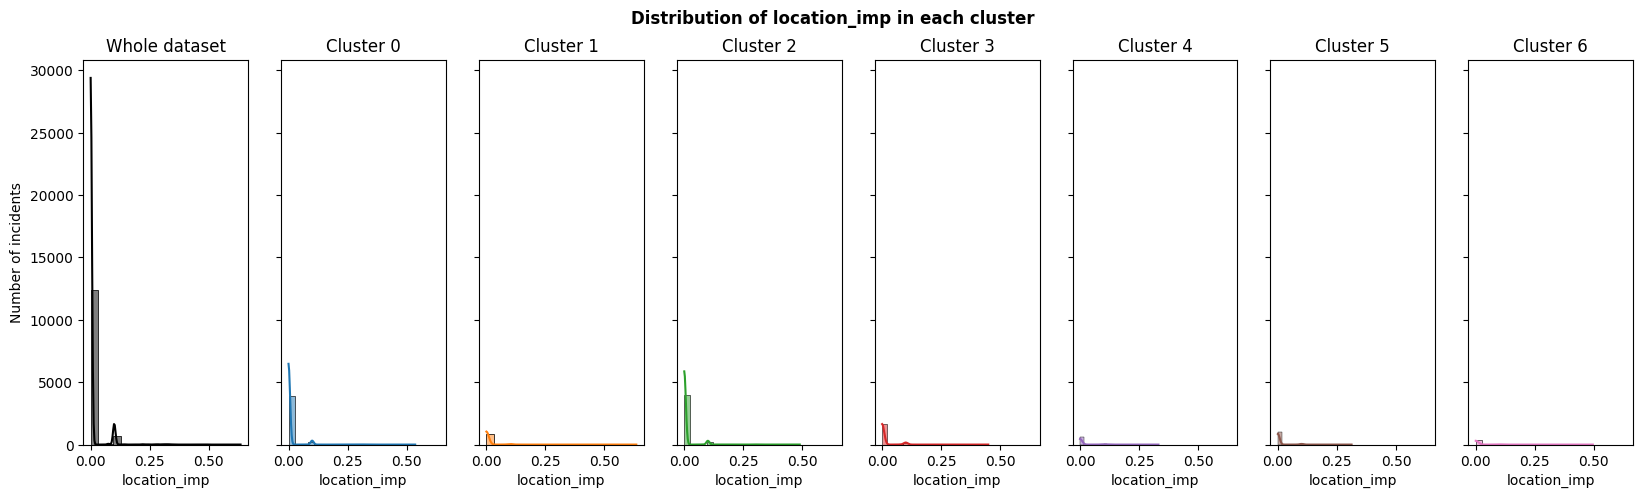

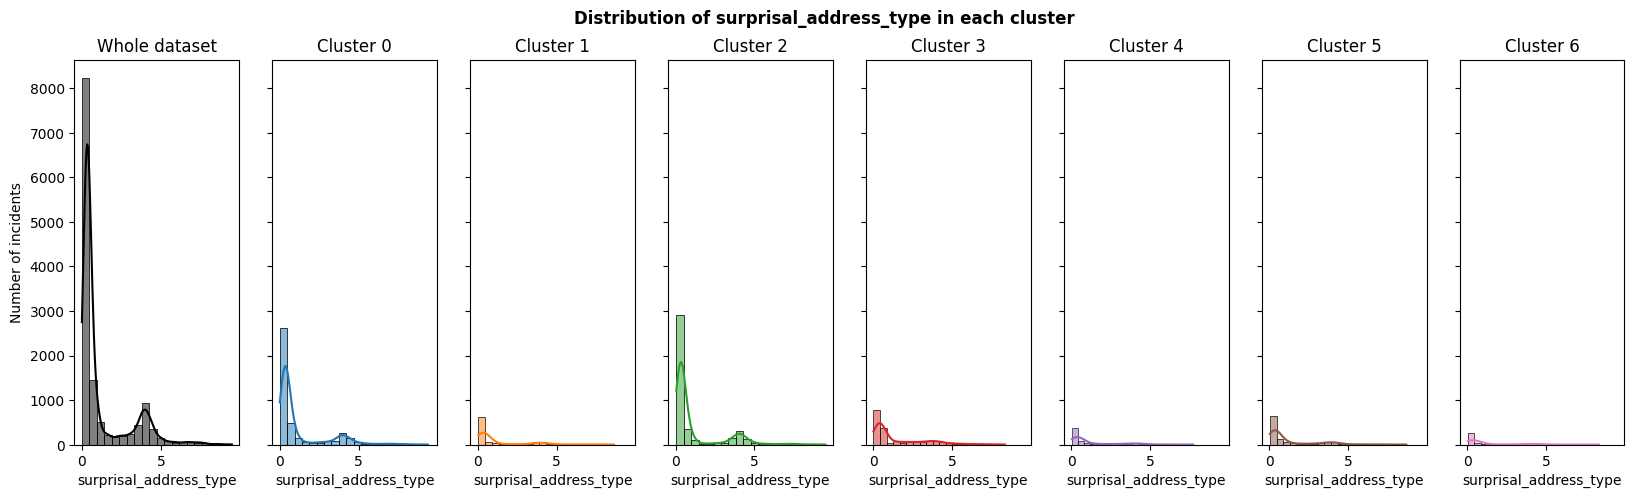

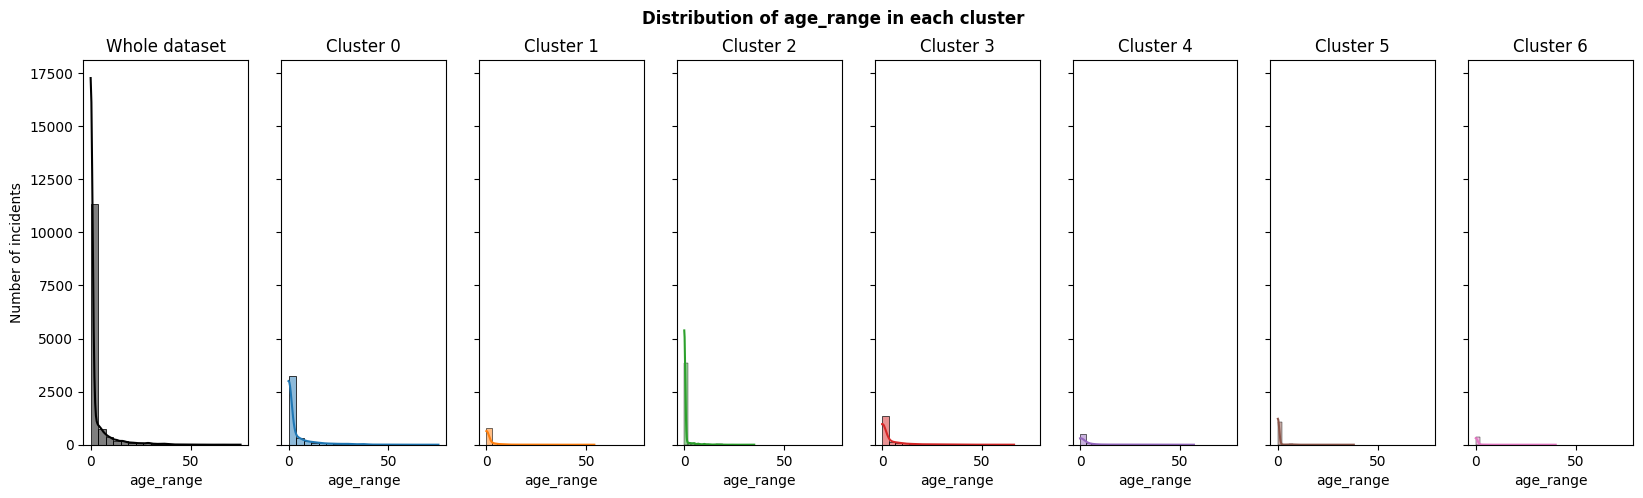

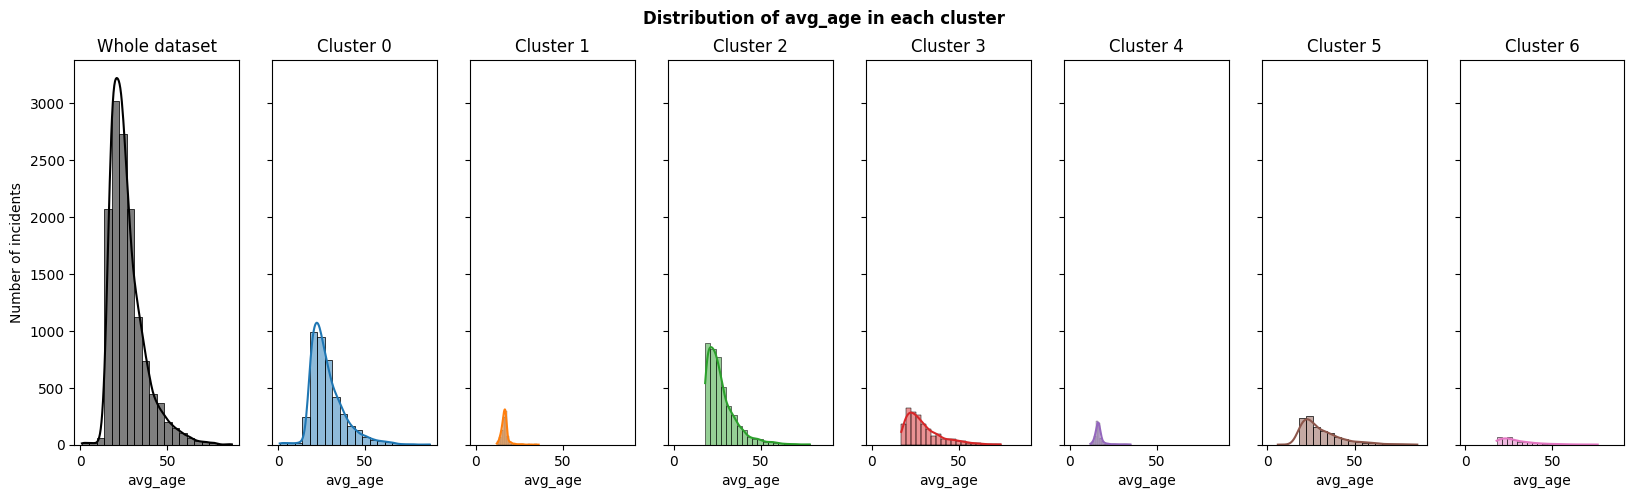

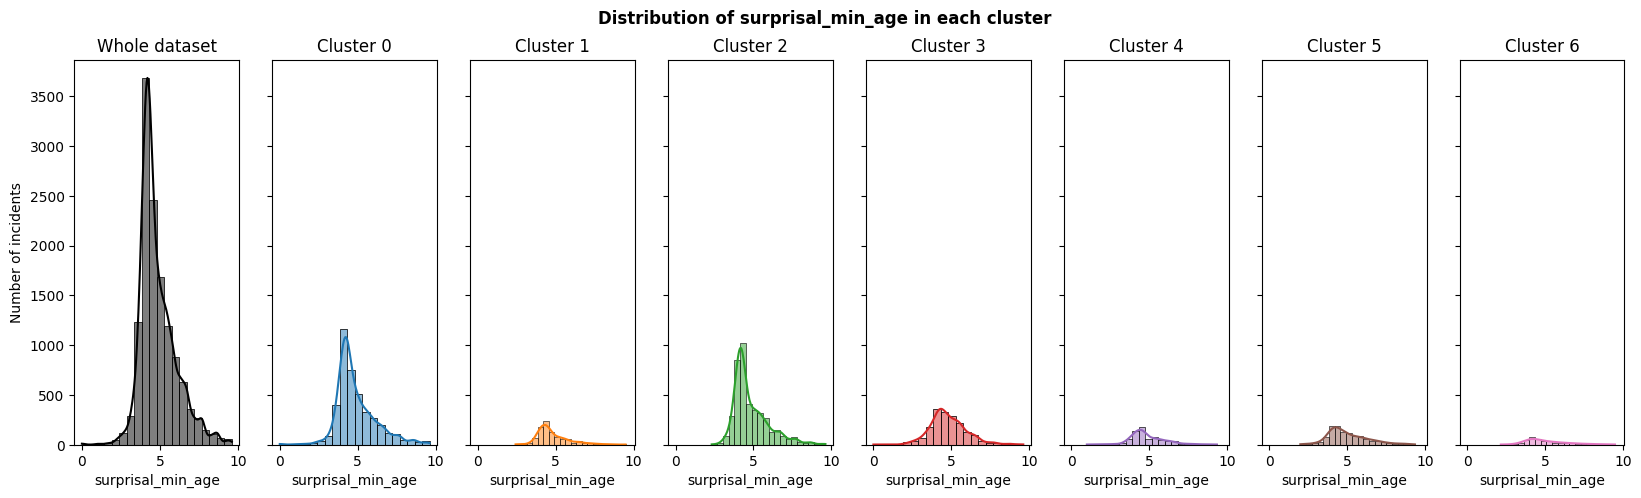

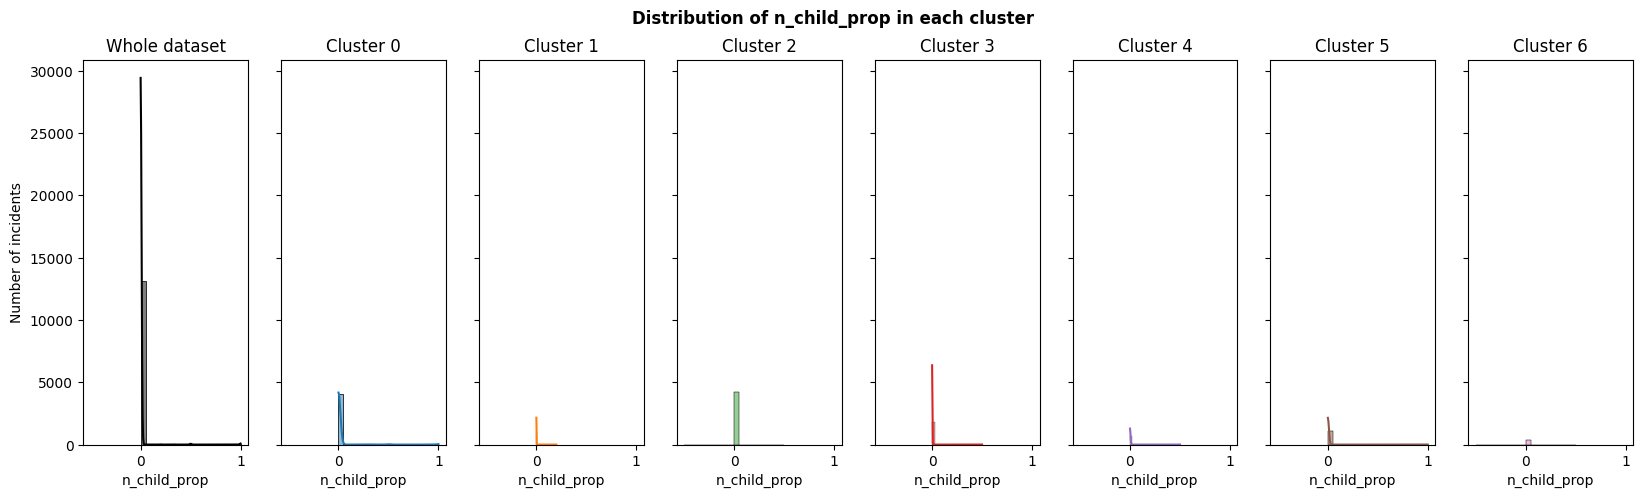

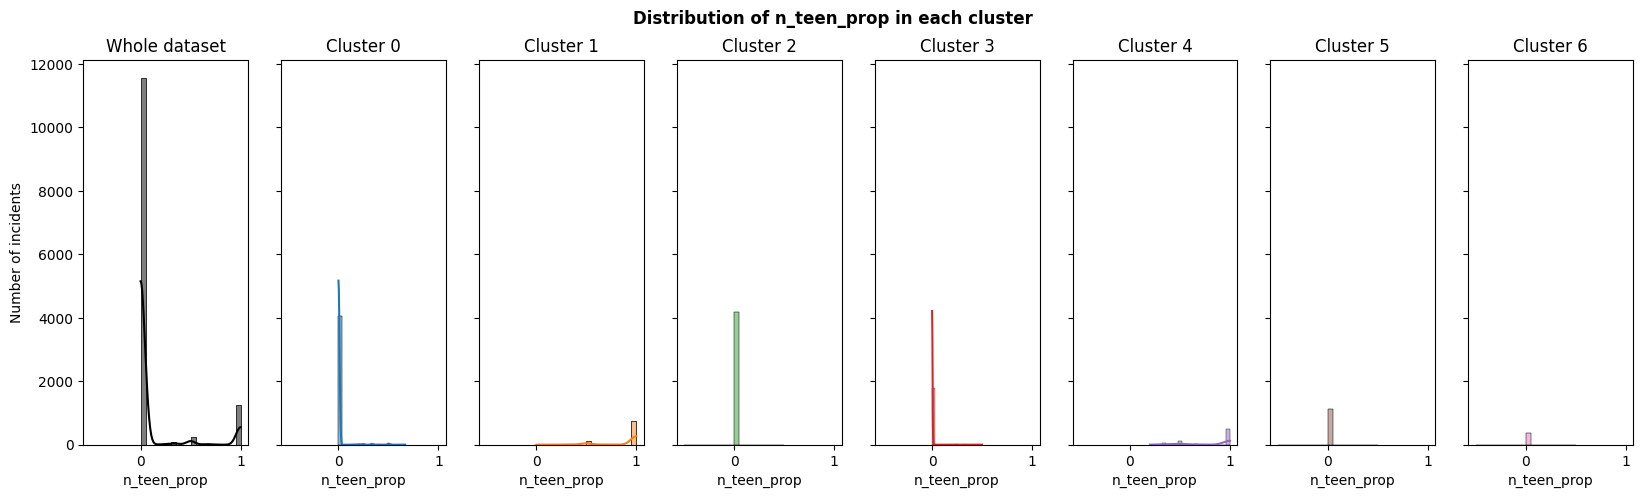

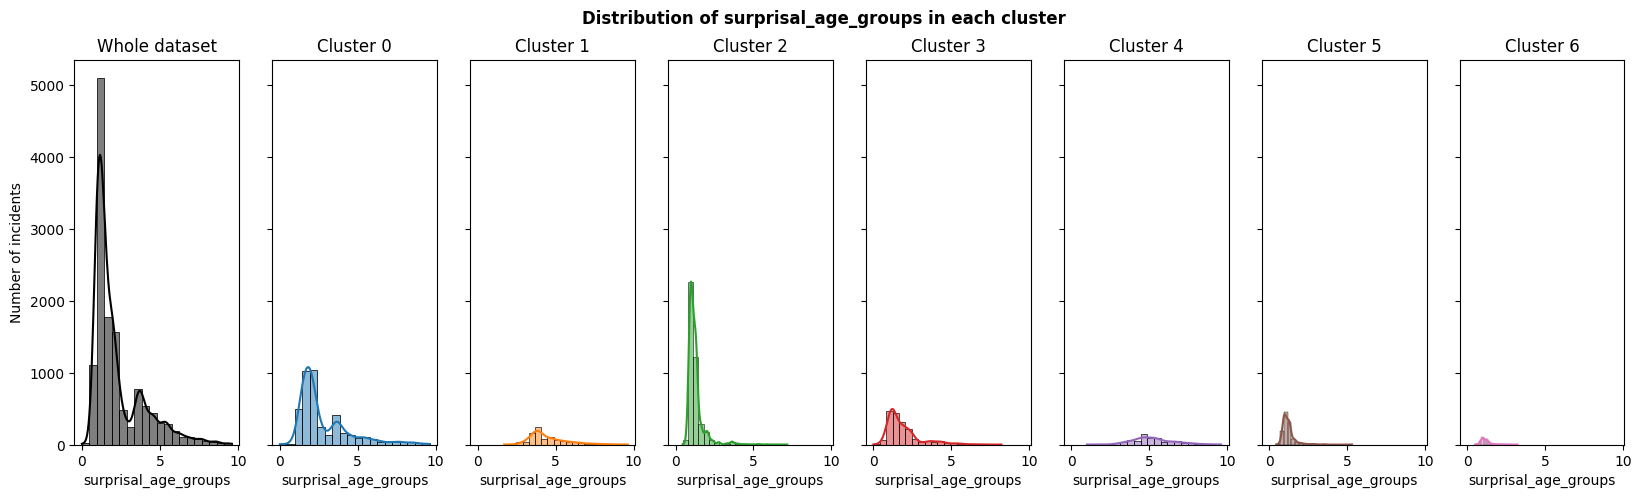

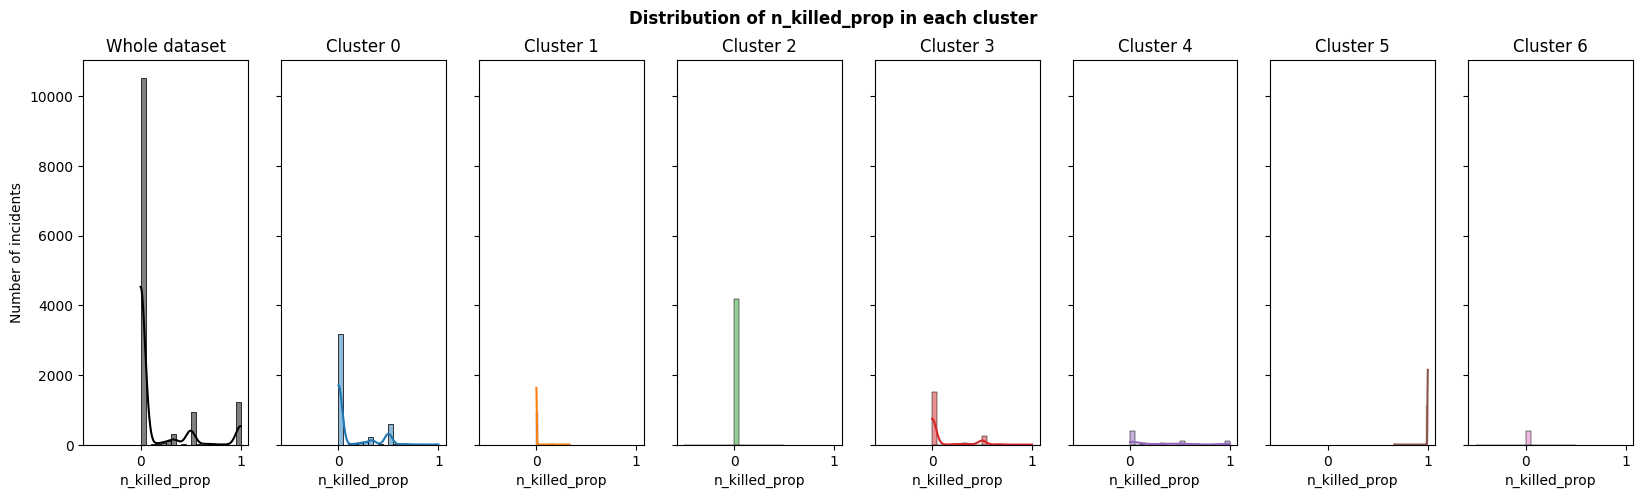

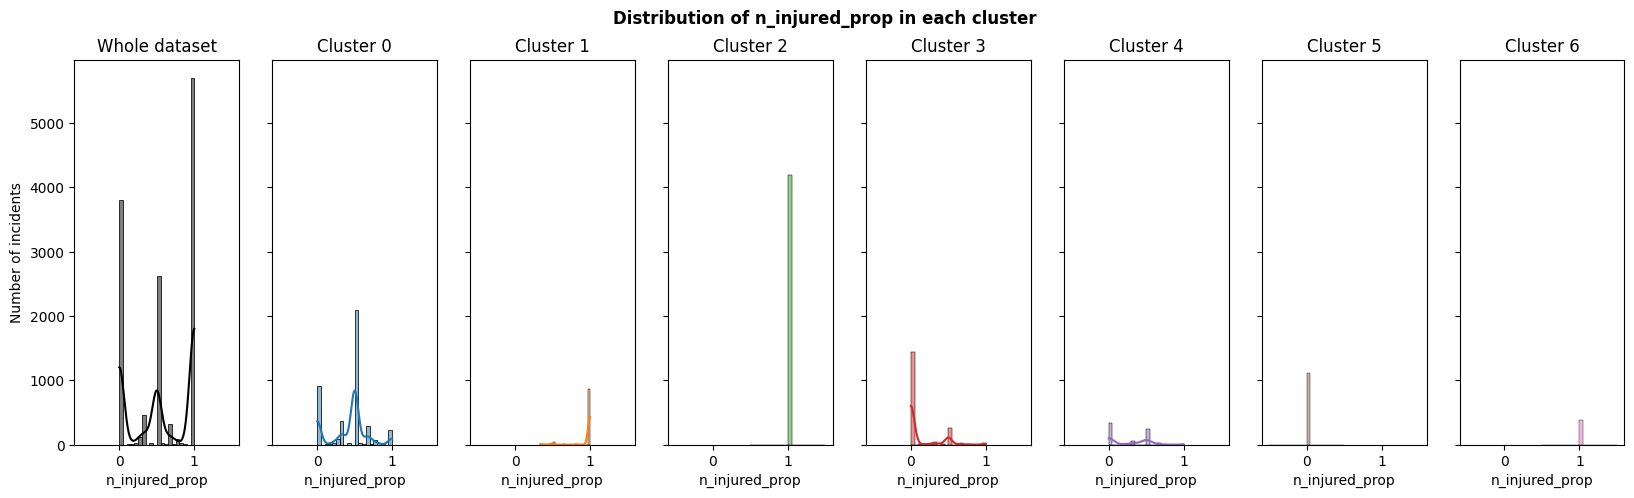

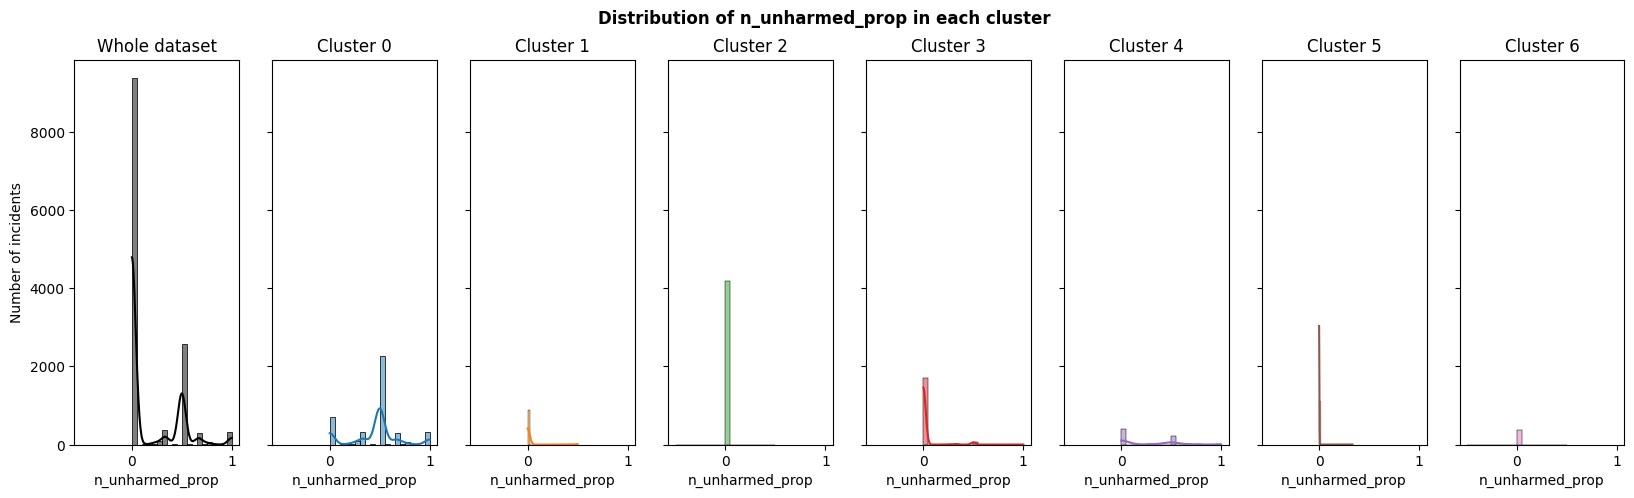

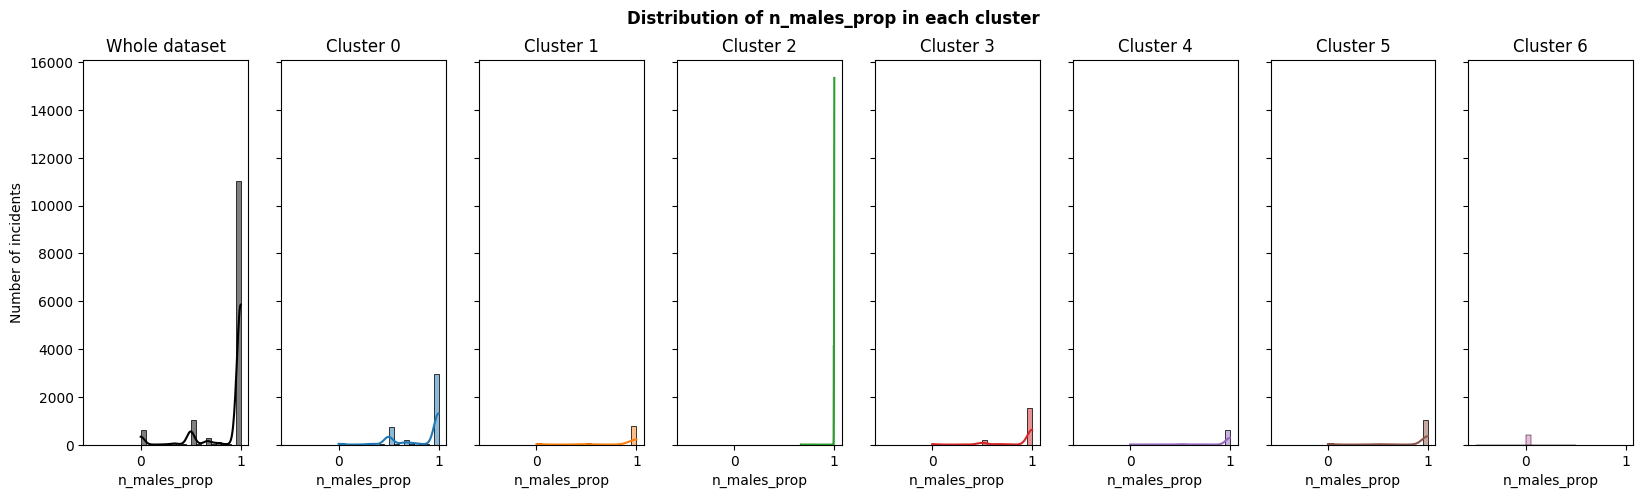

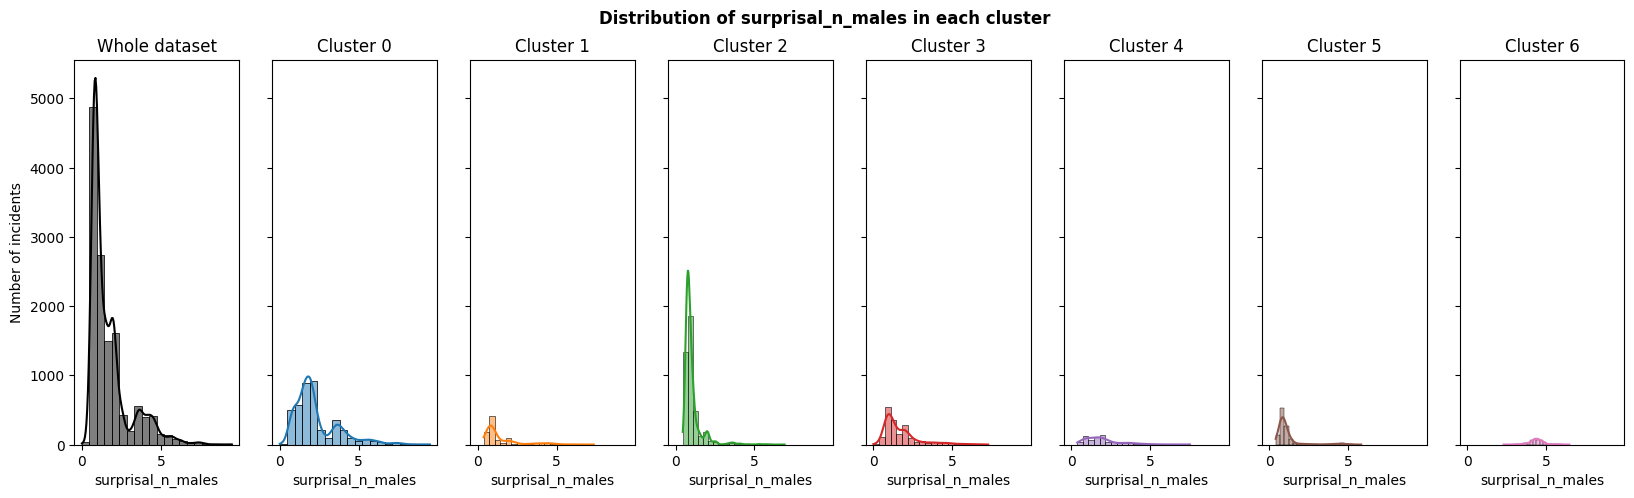

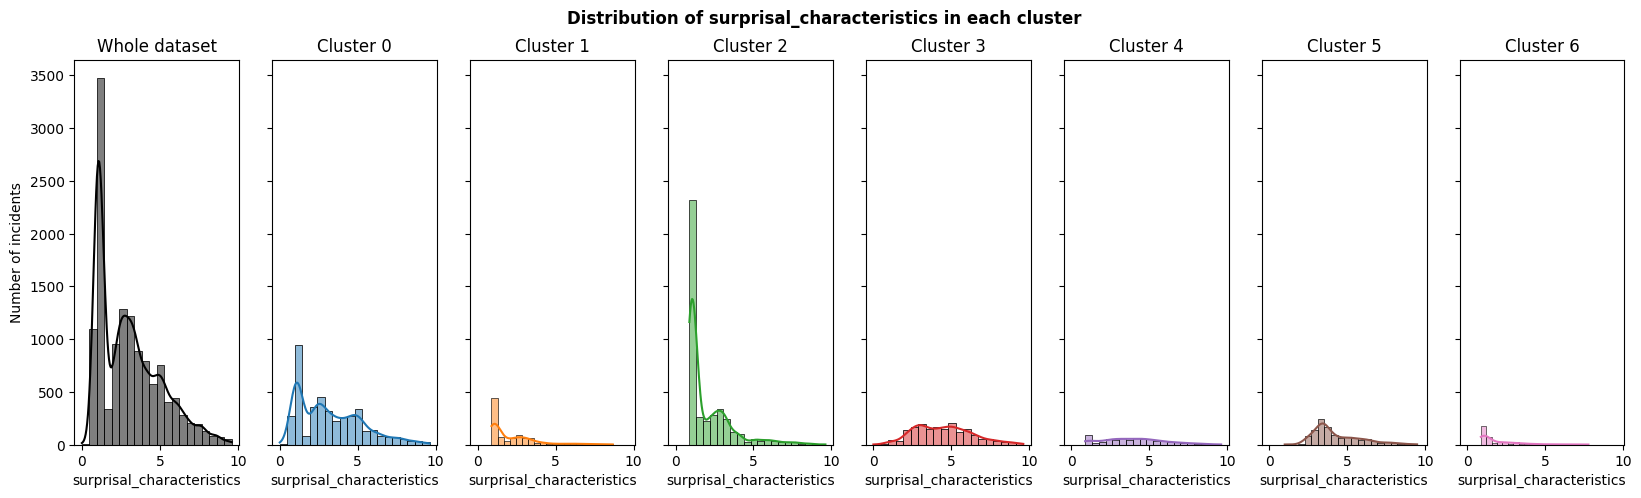

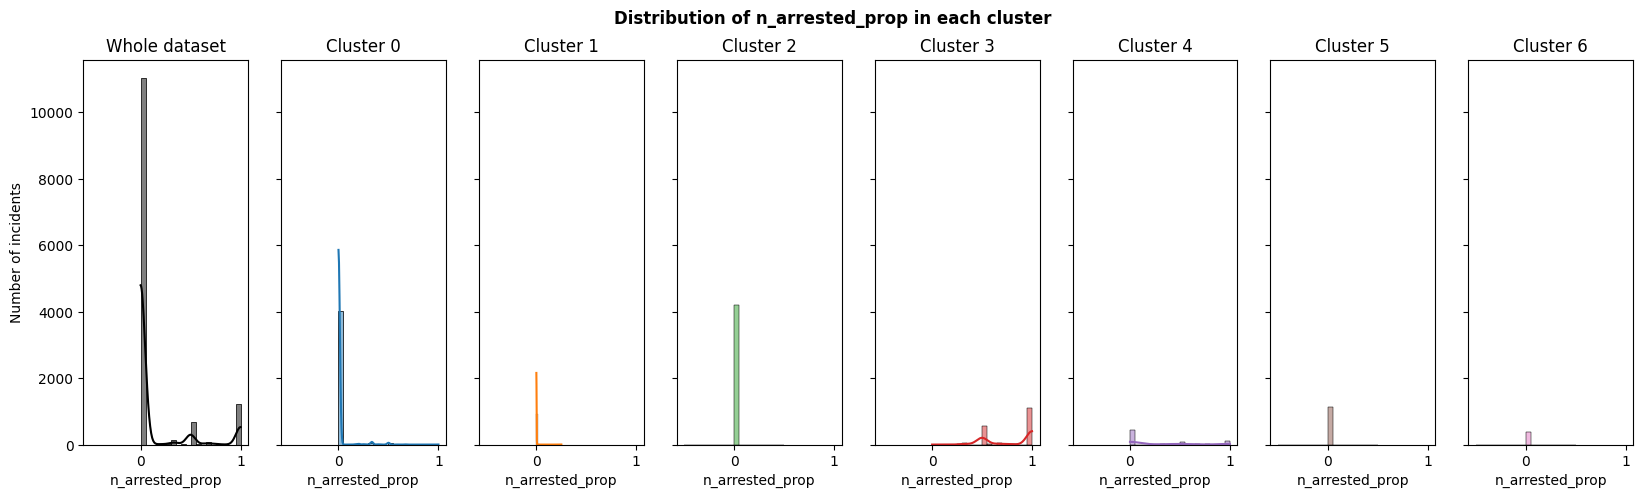

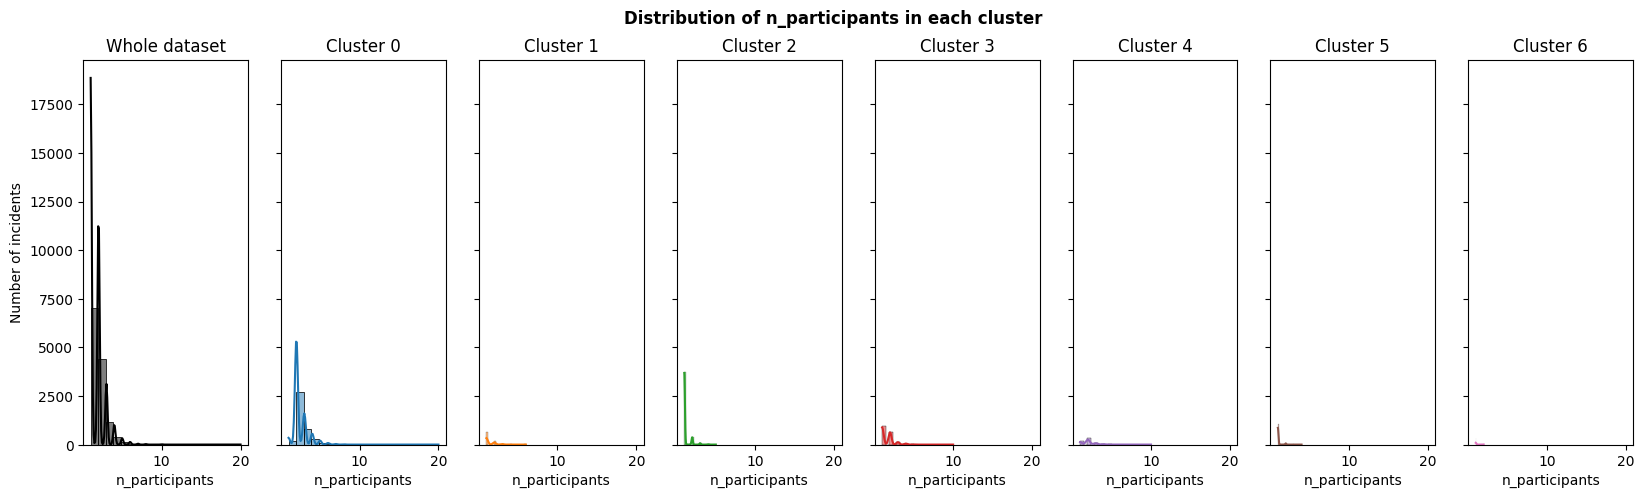

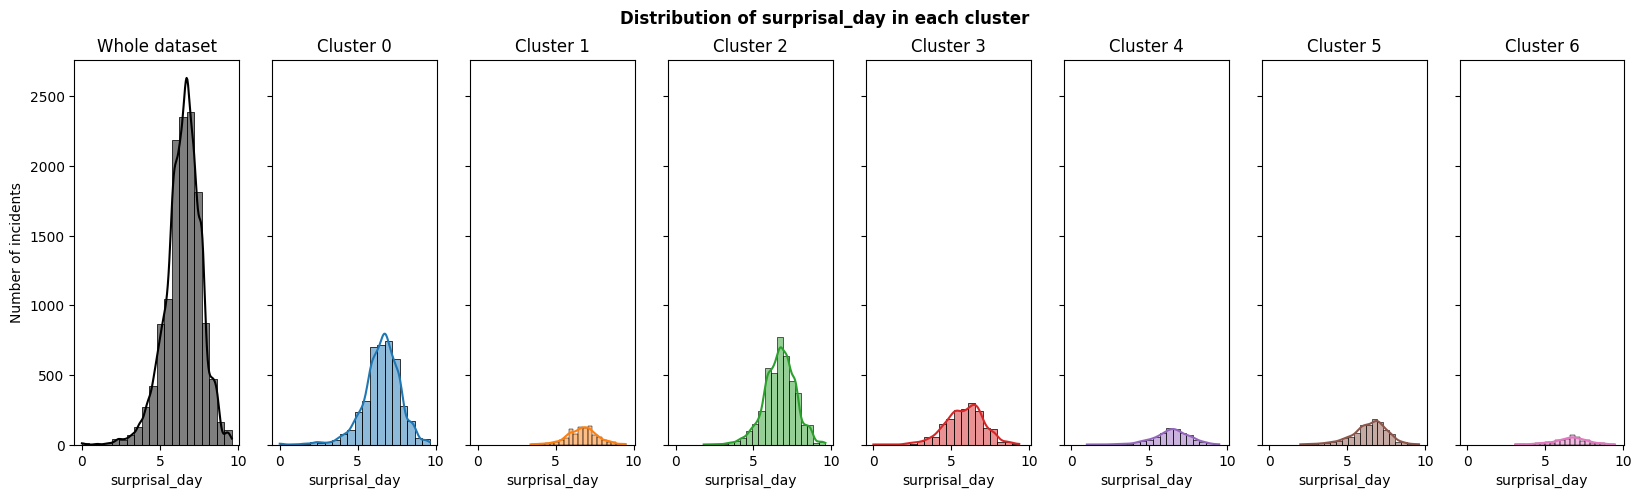

In [70]:
for feature in indicators_df.columns:
    plot_hists_by_cluster(
        df=incidents_df,
        feature=feature,
        cluster_column='cluster',
        title=f'Distribution of {feature} in each cluster'
    )

This visualization confirms what was already observed.

The attributes with the most different distributions are:
- n_teen_prop
- surprisal_age_groups
- n_killed_prop
- n_injured_prop
- n_unharmed_prop
- suprisal_n_males
- surprisal_characteristics

Now we inspect the distribution of the most relevant categorical features within the clusters:

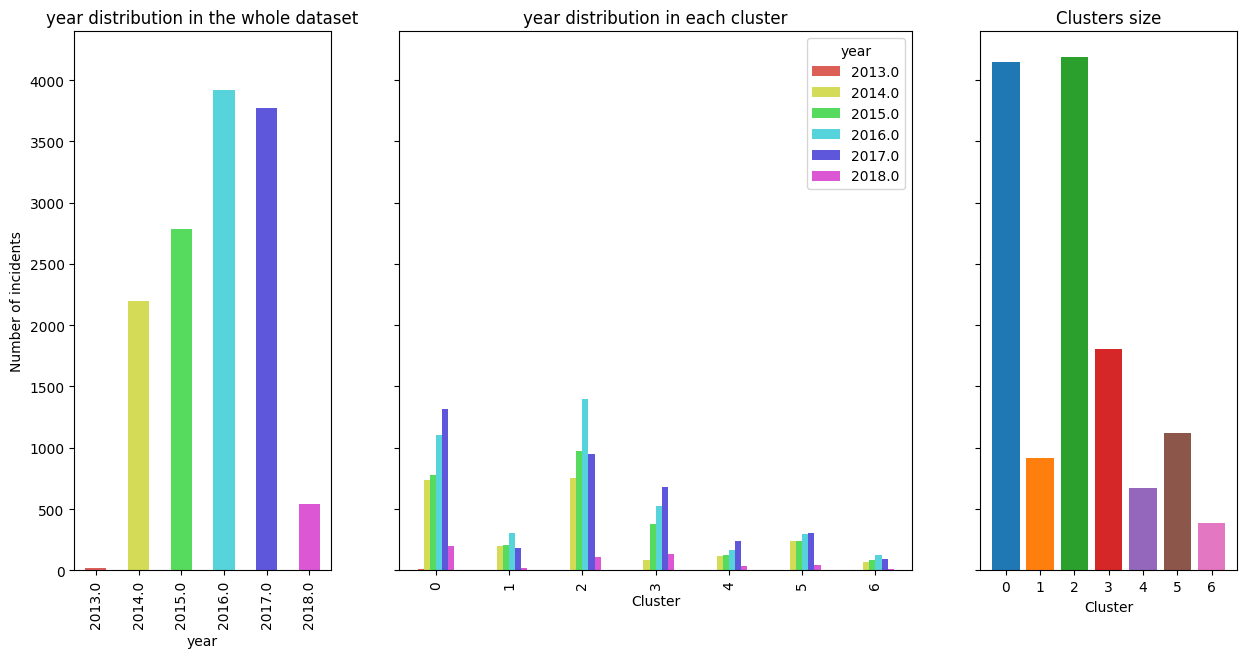

In [71]:
plot_bars_by_cluster(df=incidents_df, feature='year', cluster_column='cluster')

Cluster 1 and 2 have less incidents happened in 2017, while cluster 0 and 3 have more incidents happened in 2017.

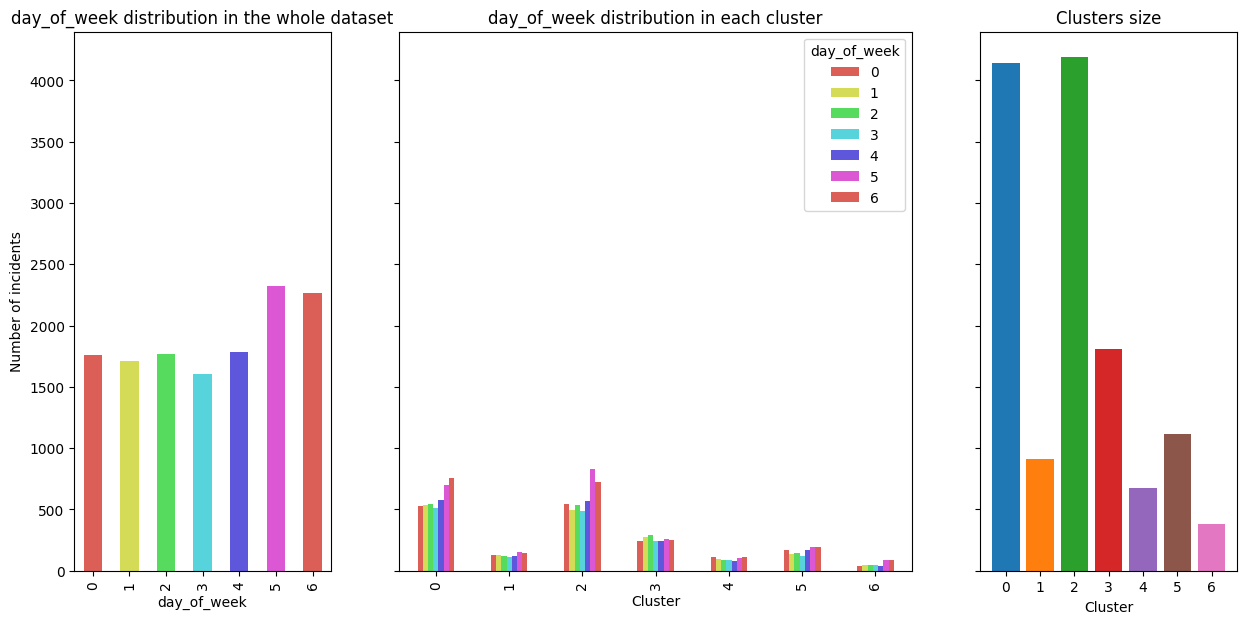

In [72]:
plot_bars_by_cluster(df=incidents_df, feature='day_of_week', cluster_column='cluster')

In cluster 2 the proportion of incidents happened in weekends is higher than in the whole dataset, while in cluster 3 and 4 it is lower.

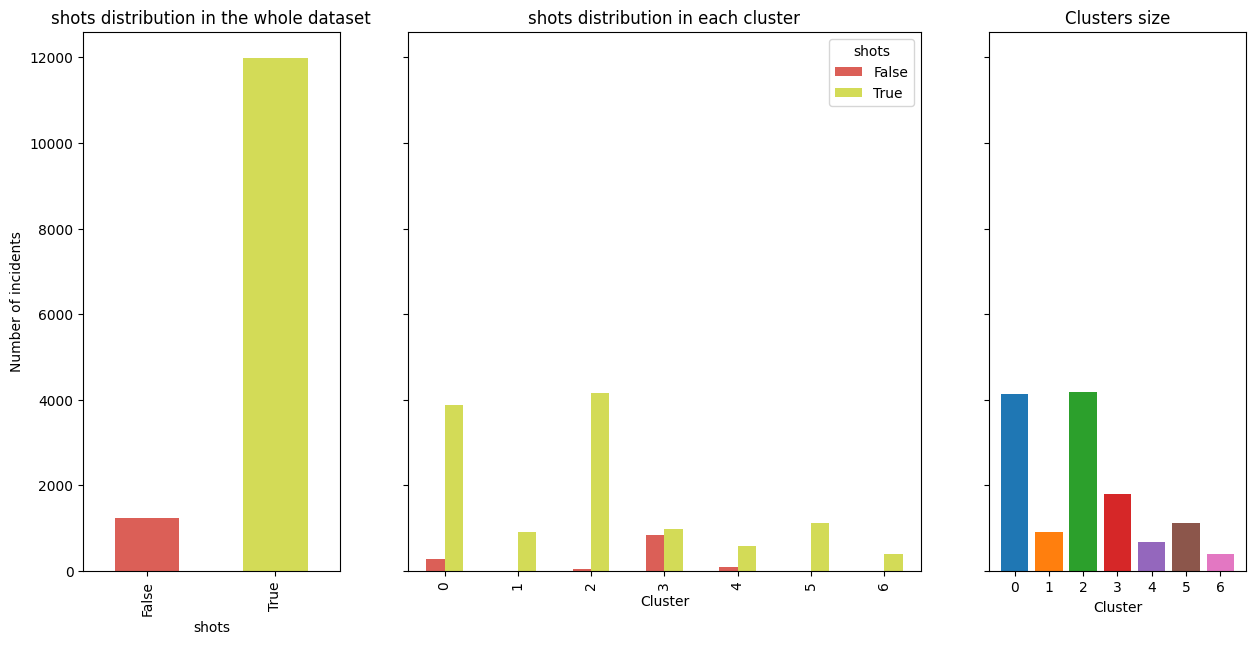

In [73]:
plot_bars_by_cluster(df=incidents_df, feature='shots', cluster_column='cluster')

Most of the non-shooting incidents are in cluster 0, 2, 3 and 4.

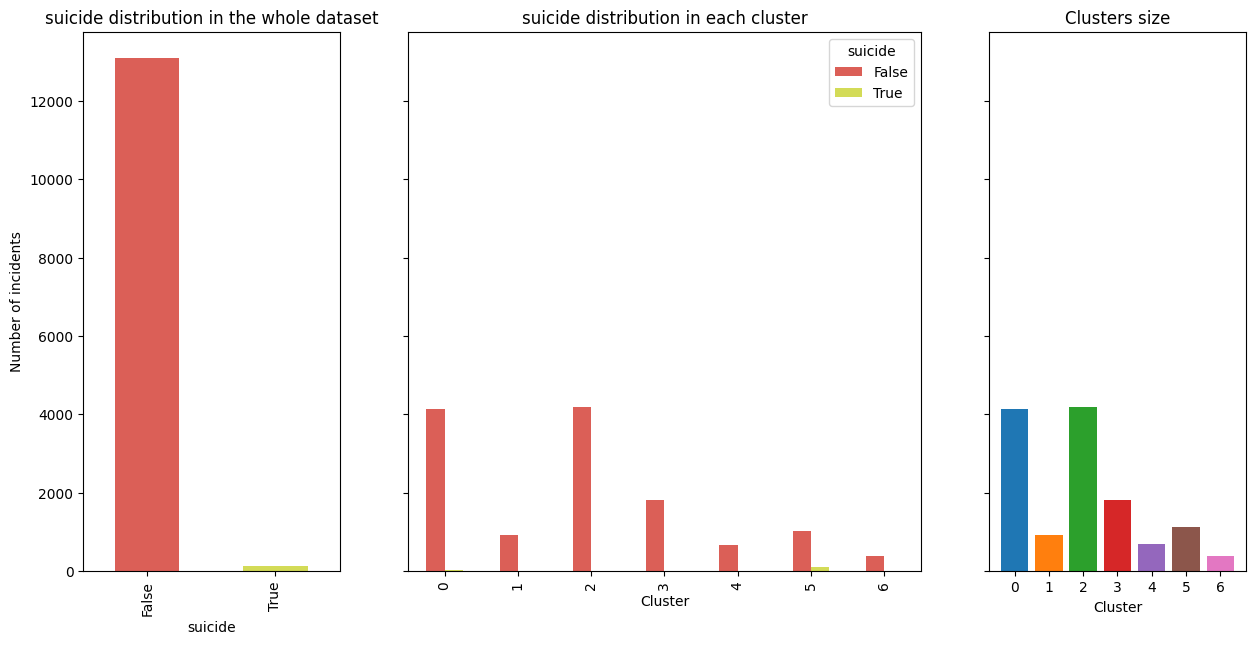

In [74]:
plot_bars_by_cluster(df=incidents_df, feature='suicide', cluster_column='cluster')

Suicides are mostly in clutser 5 as previously hypothesized.

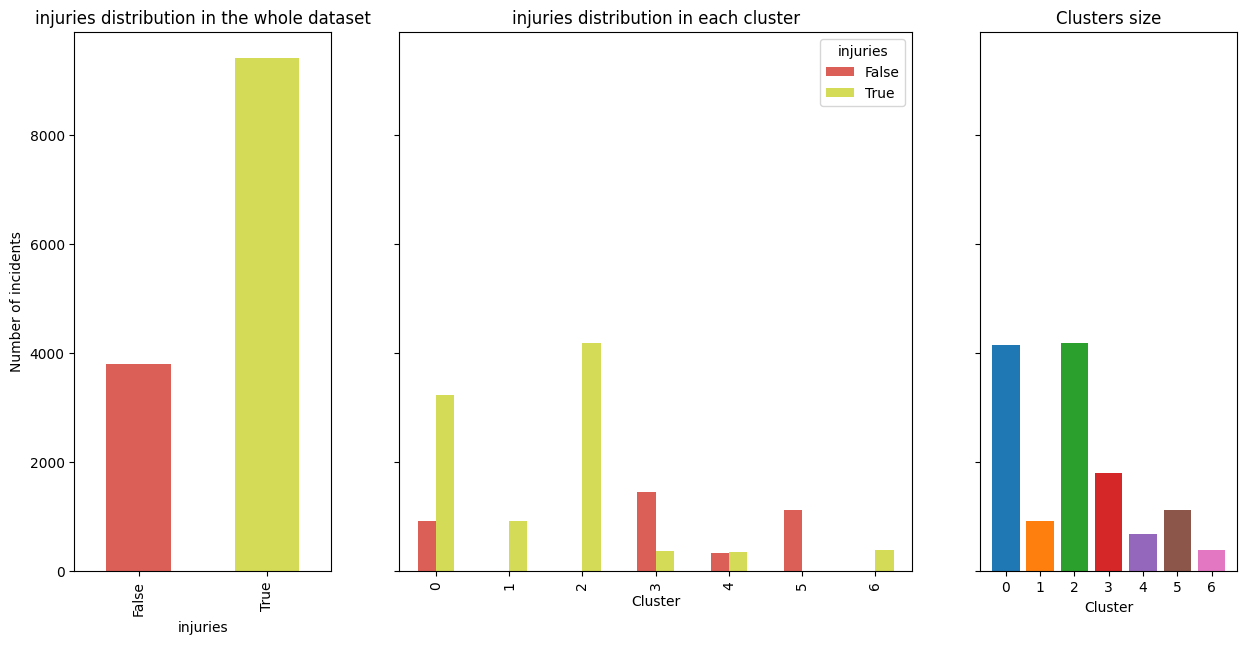

In [75]:
plot_bars_by_cluster(df=incidents_df, feature='injuries', cluster_column='cluster')

Cluster 1, 2 and 6 group incidents with injuries only.

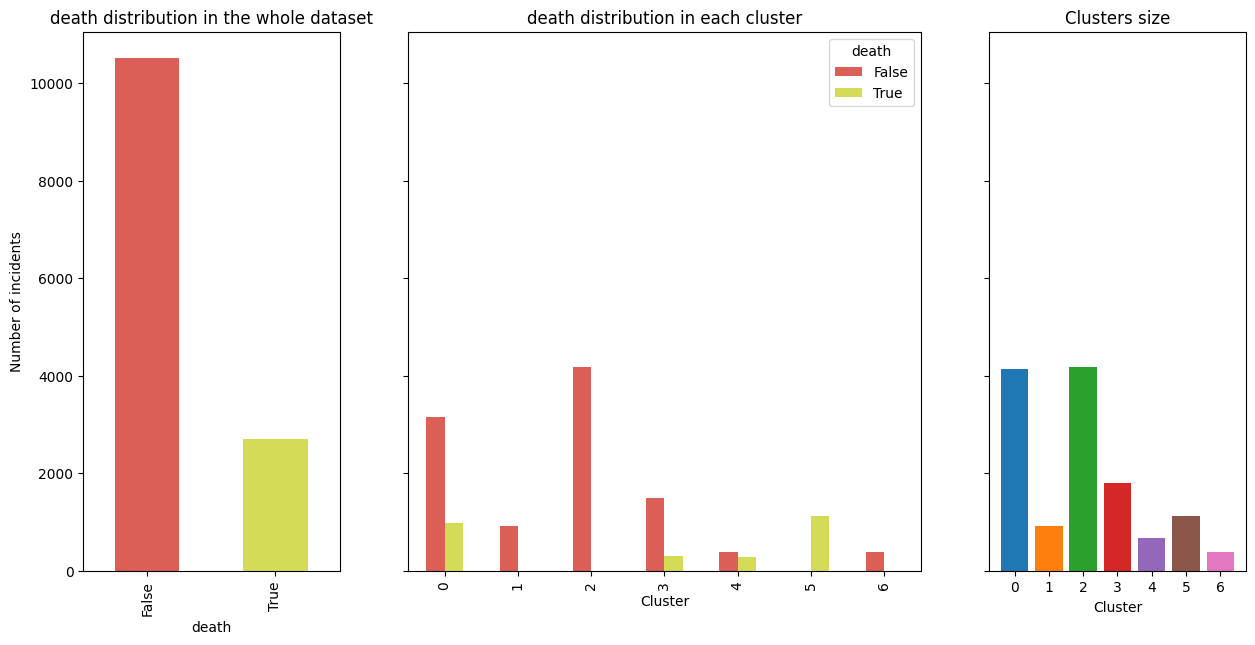

In [76]:
plot_bars_by_cluster(df=incidents_df, feature='death', cluster_column='cluster')

Fata incidents are mostly in cluster 0,3 4 and 5. Cluster 5 groups only fatal incidents.

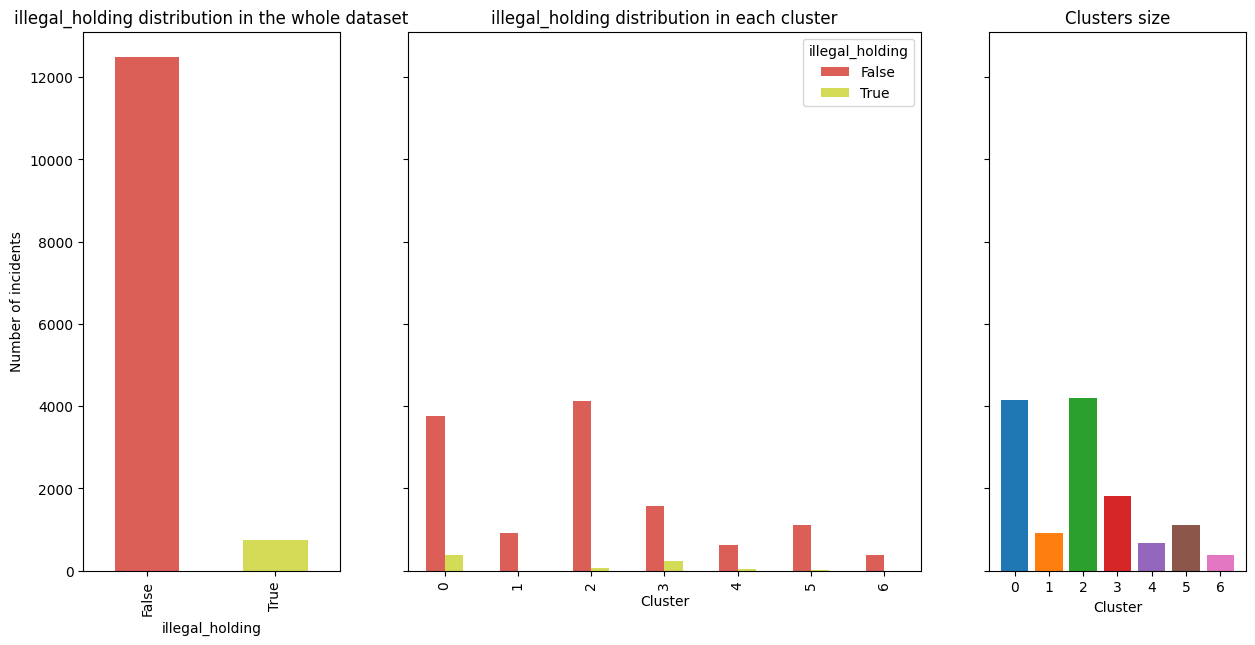

In [77]:
plot_bars_by_cluster(df=incidents_df, feature='illegal_holding', cluster_column='cluster')

Incidents tagged with 'illegal_holding' are mostly in cluster 0, 2 and 3.

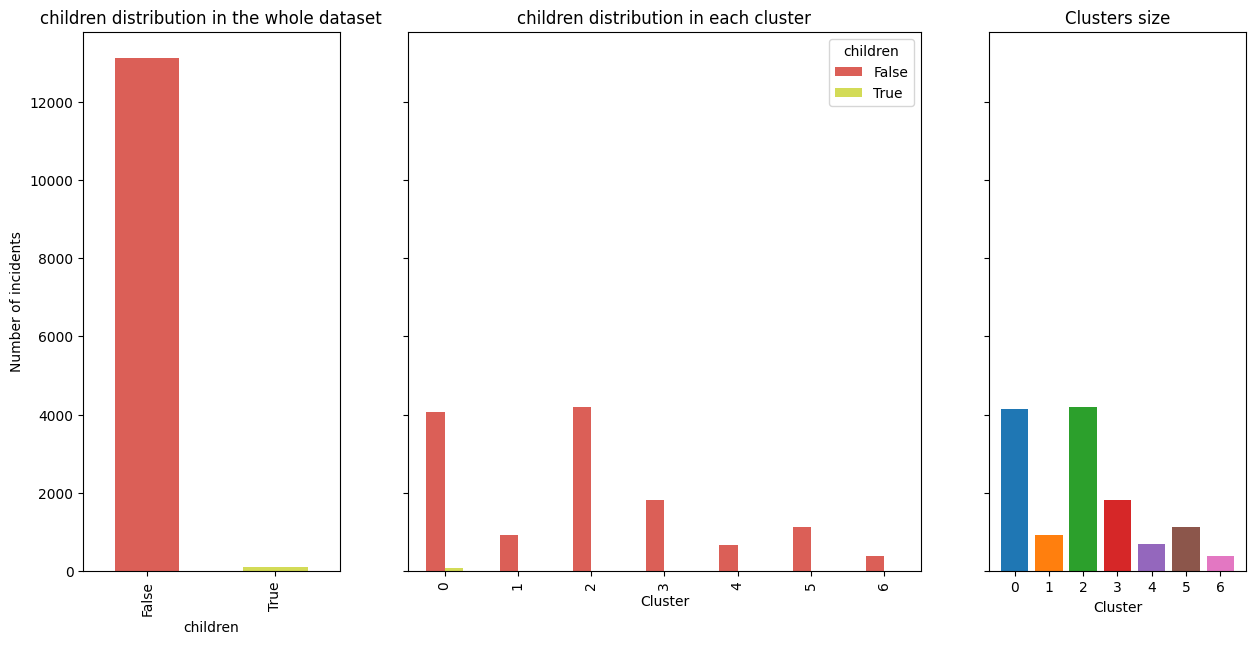

In [78]:
plot_bars_by_cluster(df=incidents_df, feature='children', cluster_column='cluster')

Incidents involving children are mostly in cluster 0.

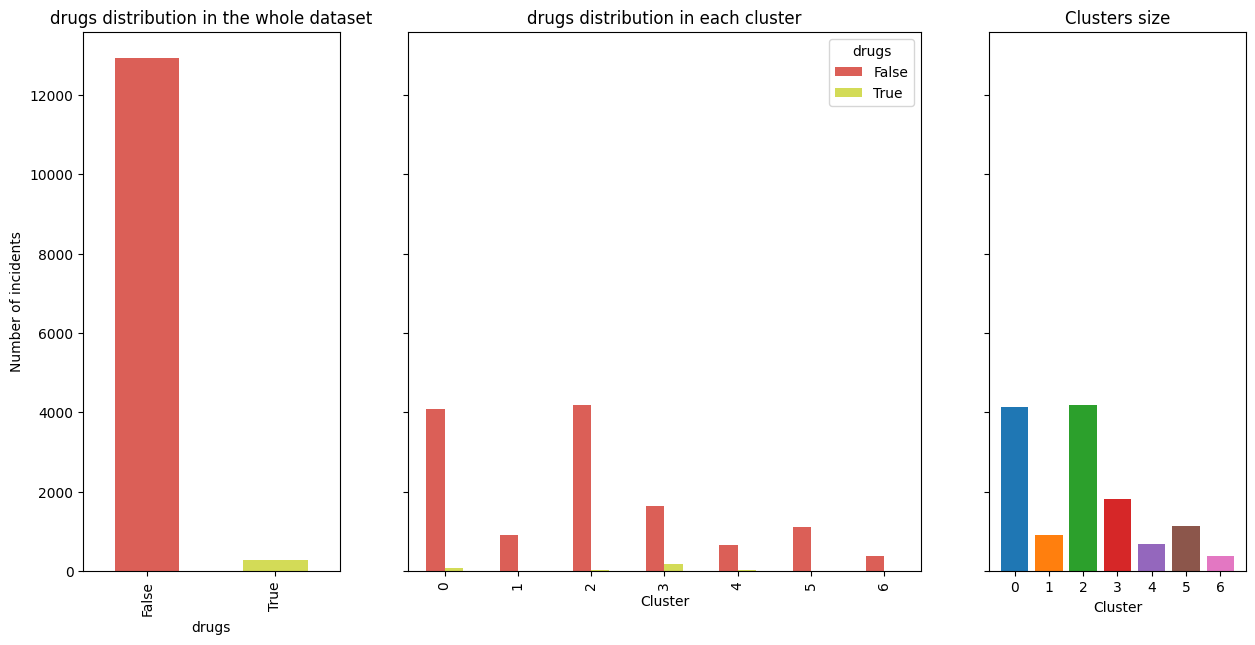

In [79]:
plot_bars_by_cluster(df=incidents_df, feature='drugs', cluster_column='cluster')

Incidents involving drugs are mostly in cluster 0 and 3.

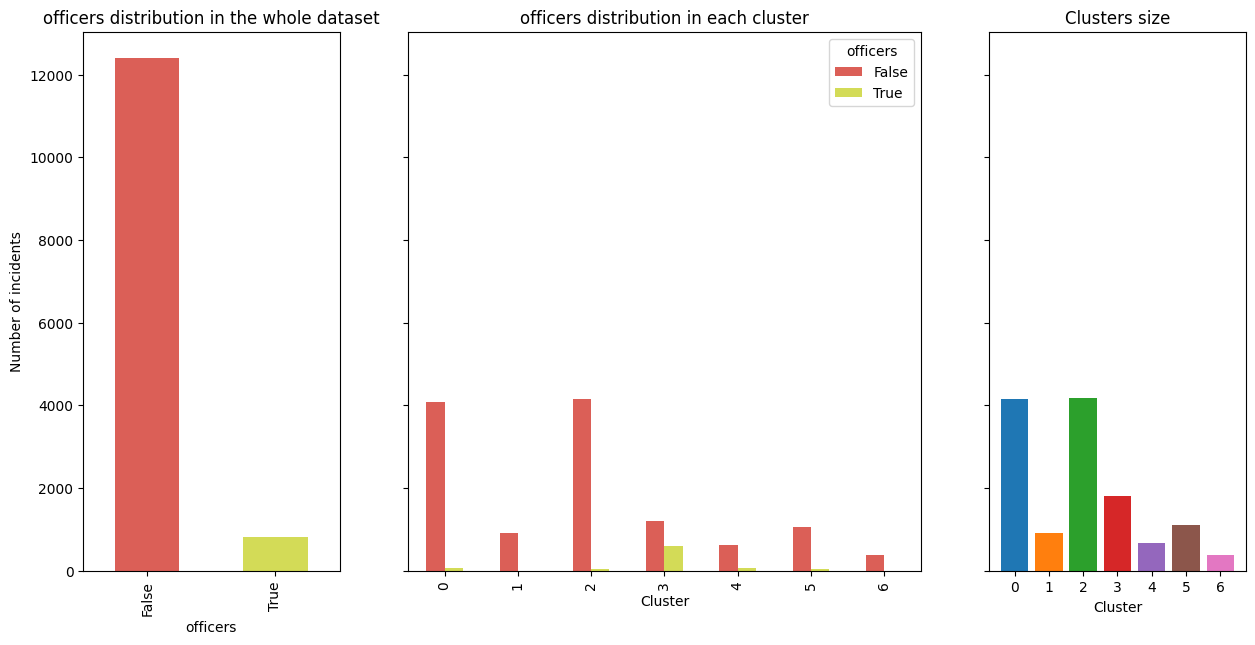

In [80]:
plot_bars_by_cluster(df=incidents_df, feature='officers', cluster_column='cluster')

Incidnets involving officers are mostly in cluster 3.

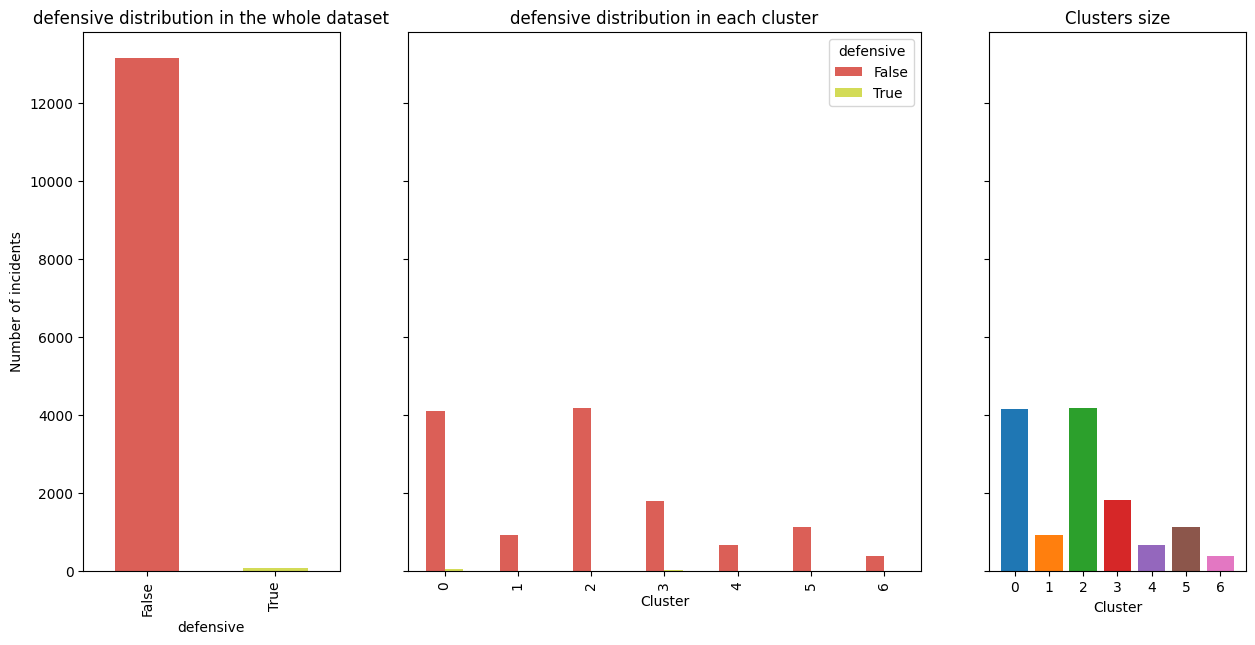

In [81]:
plot_bars_by_cluster(df=incidents_df, feature='defensive', cluster_column='cluster')

Defensive incidents are mostly in cluster 0 and 2.

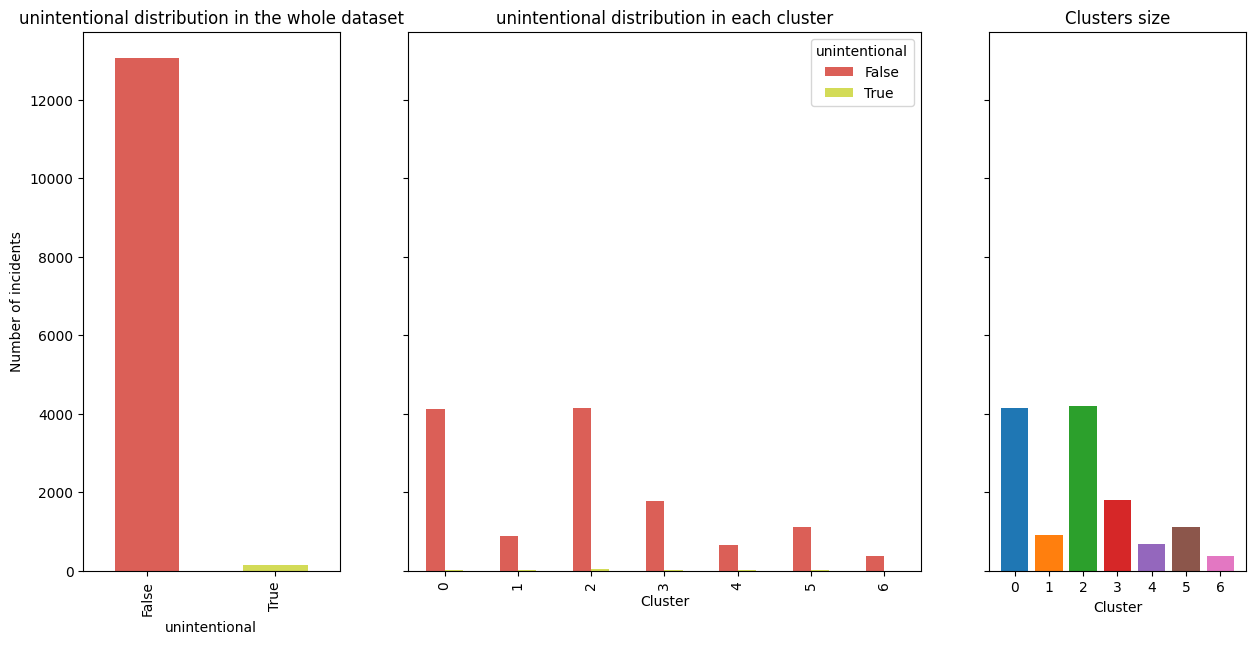

In [82]:
plot_bars_by_cluster(df=incidents_df, feature='unintentional', cluster_column='cluster')

Cluster 0 has less unintentional incidents compared to cluster 2.

### External indices

We measure the extent to which the discovered clustering structure matches some categorical features of the dataset, using the following permutation invariant scores:
- **Adjusted rand score**: this score computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. It is 0.0 for random labeling, 1.0 when the clusterings are identical and is bounded below by -0.5 for especially discordant clusterings.
- **Normalized mutual information**: is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). Mutual Information is a function that measures the agreement of the two assignments, ignoring permutations.
- **Homogeneity**: measure the degree to which each cluster contains only members of a single class; it ranges between 0 and 1, with 1 denoting perfectly homogeneous labeling.
- **Completeness**: measure the degree to ewhich data points that are members of a given class are also elements of the same cluster; it ranges between 0 and 1, with 1 denoting perfectly complete labeling.

In [83]:
incidents_df['cluster'] = clusters_info_df.loc[best_method]['cluster_labels']
incidents_df['unharmed'] = incidents_df['n_unharmed'] > 0
incidents_df['arrested'] = incidents_df['n_arrested'] > 0
incidents_df['males'] = incidents_df['n_males'] > 0
incidents_df['females'] = incidents_df['n_females'] > 0
external_scores_df = compute_permutation_invariant_external_metrics(
    incidents_df,
    'cluster',
    ['shots', 'aggression', 'suicide', 'injuries', 'death', 'drugs', 'illegal_holding', 'unharmed', 'arrested', 'males', 'females']
)
external_scores_df.to_csv(RESULTS_DIR + "hierarchical_external_scores.csv")
external_scores_df

adjusted rand score  normalized mutual information  \
feature                                                               
shots                       0.045257                       0.103206   
aggression                  0.141147                       0.194396   
suicide                     0.005569                       0.017797   
injuries                    0.197868                       0.294542   
death                       0.112758                       0.218996   
drugs                       0.006032                       0.020277   
illegal_holding             0.001334                       0.024685   
unharmed                    0.235298                       0.342733   
arrested                    0.182932                       0.351128   
males                       0.042458                       0.120774   
females                     0.044305                       0.105518   

                 homogeneity  completeness  
feature                                     
shots               0.326136      0.061303  
aggression          0.399959      0.128402  
suicide             0.304827      0.009166  
injuries            0.551776      0.200889  
death               0.465600      0.143167  
drugs               0.173055      0.010769  
illegal_holding     0.105911      0.013970  
unharmed            0.640033      0.234026  
arrested            0.819837      0.223405  
males               0.586974      0.067312  
females             0.279246      0.065049

The most homogeneous category is 'arrested', however it is not complete. Completeness is quite low for all the categories.

We save the clustering results for later use:

In [84]:
pd.DataFrame(
    {'cluster': clusters_info_df.loc[best_method]['cluster_labels']}
).to_csv(RESULTS_DIR + "hierarchical_clusters.csv")
pd.DataFrame({
        'BBS': np.NaN,
        'SSE': np.NaN,
        'calinski_harabasz_score': np.NaN,
        'davies_bouldin_score': np.NaN,
        'model': best_method,
        'n_iter': np.NaN,
        'silhouette_score': clusters_info_df.loc['ward']['silhouette_score']
    },
    index=[0]
).to_csv(RESULTS_DIR + "hierarchical_internal_scores.csv")

## Final considerations
Advantages of hierarchical clustering:
- Do not have to assume any particular number of clusters
- Suitable for data with a nested or hierarchical structure

Disadvantages of hierarchical clustering:
- No global objective function is directly minimized (once a decision is made to merge two clusters, it cannot be undone at a later time)
- Is expensive in terms of computational and storage requirements

Furthermore - as outlined above - each different proximity measures has its own advantages and disadvantages (e.g. sensitivity to noise and outliers or difficulty in handling clusters of different sizes and non-globular shapes).